In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats
import string

In [2]:
#Substitution matrix becomes more complicated for protein-sequence alignment compared to DNA-sequence alignment since the
#alphabet has increased from 4 to 20. Different amino acids partially match in chemical properties for which a basic
#scoring scheme of 1 for a match and 0 for a mismatch is not enough
#this matrix defines the cost of a substitution a--> b


#           A   R   N   D   C   Q   E  G   H   I   L   K   M   F   P   S   T   W   Y  V
BLOSUM50 = [5, -2, -1, -2, -1, -1, -1, 0, -2, -1, -2, -1, -1, -3, -1,  1,  0, -3, -2, 0, #A
            -2, 7, -1, -2, -4, 1, 0, -3, 0, -4, -3, 3, -2, -3, -3, -1, -1, -3, -1, -3, #R
            -1, -1, 7, 2, -2, 0, 0, 0, 1, -3, -4, 0, -2, -4, -2, 1, 0, -4, -2, -3, #N
            -2, -2, 2, 8, -4, 0, 2, -1, -1, -4, -4, -1, -4, -5, -1, 0, -1, -5, -3, -4, #D
            -1, -4, -2, -4, 13, -3, -3, -3, -3, -2, -2, -3, -2, -2, -4, -1, -1, -5, -3, -1, #C
            -1, 1, 0, 0, -3, 7, 2, -2, 1, -3, -2, 2, 0, -4, -1, 0, -1, -1, -1, -3, #Q
            -1, 0, 0, 2, -3, 2, 6, -3, 0, -4, -3, 1, -2, -3, -1, -1, -1, -3, -2, -3, #E
            0, -3, 0, -1, -3, -2, -3, 8, -2, -4, -4, -2, -3, -4, -2, 0, -2, -3, -3, -4, #G
            -2, 0, 1, -1, -3, 1, 0, -2, 10, -4, -3, 0, -1, -1, -2, -1, -2, -3, 2, -4, #H
            -1, -4, -3, -4, -2, -3, -4, -4, -4, 5, 2, -3, 2, 0, -3, -3, -1, -3, -1,  4, #I
            -2, -3, -4, -4, -2, -2, -3, -4, -3,  2,  5, -3,  3,  1, -4, -3, -1, -2, -1, 1, #L
            -1, 3, 0, -1, -3, 2, 1, -2, 0, -3, -3, 6, -2, -4, -1, 0, -1, -3, -2, -3, #K
            -1, -2, -2, -4, -2,  0, -2, -3, -1,  2,  3, -2,  7,  0, -3, -2, -1, -1,  0,  1, #M
            -3, -3, -4, -5, -2, -4, -3, -4, -1,  0,  1, -4,  0,  8, -4, -3, -2,  1,  4, -1, #F
            -1, -3, -2, -1, -4, -1, -1, -2, -2, -3, -4, -1, -3, -4, 10, -1, -1, -4, -3, -3, #P
            1, -1,  1,  0, -1,  0, -1,  0, -1, -3, -3,  0, -2, -3, -1,  5,  2, -4, -2, -2, #S
            0, -1,  0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1,  2,  5, -3, -2,  0, #T
            -3, -3, -4, -5, -5, -1, -3, -3, -3, -3, -2, -3, -1,  1, -4, -4, -3, 15,  2, -3, #W
            -2, -1, -2, -3, -3, -1, -2, -3,  2, -1, -1, -2,  0,  4, -3, -2, -2,  2,  8, -1, #Y
            0, -3, -3, -4, -1, -3, -3, -4, -4,  4,  1, -3,  1, -1, -3, -2,  0, -3, -1, 5] #V

#converting to array for easier manipulation
BLOSUM50 = np.asarray(BLOSUM50)
BLOSUM50 = np.reshape(BLOSUM50, (20, 20)) #substitution matrix

AA = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V'] #Amino Acid bases
#the index corresponding to the letter in AA corresponds to the row/column index of BLOSUM50

In [6]:
# 1.implement Needleman-Wunsch for proteins (Global sequence alignment) 
#As time evolves, mutations occur to the nucleotide sequences in the form of insertions, deletions and replacements.
#At time t- the sequences are similar but no longer identical. We will never be able to observe the 2 sequences at time t0
#but we would like to deduce if the 2 sequences seen at time t descended from a common ancestor. By computing a similarity
#score of the 2 sequences at time t, we can posture that the 2 sequences had a common ancestor if this score is high.

#the algorithm
#want to ﬁnd the minimum edit distance (measures the minimum number of moves to go from one sequence to another)
#measuring how to change a to b where the price of a substitution is s(a,b) and of a gap (insertion or deletion) d = −8. 

In [7]:
def init_sim_matrix(A, B):
    "initialise similarity matrix with zeroes and pointer matrix with D"
    return (np.asarray([[0 for x in range(len(A)+1)] for x in range(len(B)+1)]),
            np.asarray([['-' for x in range(len(A)+1)] for x in range(len(B)+1)]))

In [8]:
def fill_sim_mat_NW(A, B, Gap, sim, ptr):
    "fill similarity and pointer matrices using Needleman-Wunsch algorithm"
    
    #filling first row with gap multiples
    for i in range(len(A)+1):
        sim[0][i] = Gap*i
        ptr[0][i] = 'H'
        
    #filling first column with gap multiples  
    for j in range(len(B)+1):
        sim[j][0] = Gap*j
        ptr[j][0] = 'V'
        
    ptr[0][0] = '-'
    #filling remainder of matrix- 'i' is column index, 'j' is row index
    #index of strings is always one less than index of matrix
    #finding index of BLOSUM50 matrix based on sequence elements under consideration
    for j in range(1,len(B)+1):
        for i in range(1,len(A)+1):
            for k in range(len(AA)):
                if (A[i-1] == AA[k]):
                    col = k #column index of BLOSUM50 corresponding to the letter A[i-1]
            for l in range(len(AA)):
                if (B[j-1] == AA[l]):
                    row = l #row index of BLOSUM50 corresponding to the letter B[j-1]
                  
            match =  sim[j-1][i-1] + BLOSUM50[row][col]
            delete = sim[j-1][i] + Gap
            insert = sim[j][i-1] + Gap
            sim[j][i] = max(match, delete, insert)
            
            #filling ptr matrix- returned for traceback
            #H = keep horizontal value, V = keep vertical value
            if(sim[j][i] == match):
                ptr[j][i] = 'D'
            elif(sim[j][i] == delete):
                ptr[j][i] = 'V'
            elif(sim[j][i] == insert):
                ptr[j][i] = 'H'
    
    return sim, ptr

In [9]:
#traceback
def traceback_NW(ptr, A, B):
    "traceback for best match using Needleman-Wunsch algorithm"
    #initialising best match arrays with extra spaces for gaps
    if (len(A)>len(B)):
        best_match_A = np.asarray(['-' for x in range(len(A)+3)])
        best_match_B = np.asarray(['-' for x in range(len(A)+3)])
    else:
        best_match_A = np.asarray(['-' for x in range(len(B)+3)])
        best_match_B = np.asarray(['-' for x in range(len(B)+3)])
    
    index = len(best_match_A) #for indexing best match arrays
        
    #bottom right index of pointer matrix
    col = len(A)
    row = len(B)

    i = 0 #column iterating variable of pointer matrix
    j = 0 #row iterating variable of pointer matrix
    
    test = ptr[row][col] #element of pointer matrix under consideration

    for x in range(index): #iterate through best match arrays
        #traceback in direction based on ptr matrix
        if(test == 'D'):
            best_match_A[index-x-1] = A[(col-1)-i]
            best_match_B[index-x-1] = B[(row-1)-j]
            i = i+1
            j = j+1
        elif(test == 'H'):
            best_match_A[index-x-1] = A[(col-1)-i]
            best_match_B[index-x-1] = '-'
            i = i+1
            j = j
        elif(test == 'V'):
            best_match_A[index-x-1] = '-'
            best_match_B[index-x-1] = B[(row-1)-j]
            i = i
            j = j+1
        else:
            best_match_A[index-x-1] = '-'
            best_match_B[index-x-1] = '-'
            
        test = ptr[row-j][col-i] #update test element
    
    return ''.join(list(best_match_A)), ''.join(list(best_match_B))       

In [10]:
#Run this on HEAGAWGHEE versus PAWHEAE 
A = "HEAGAWGHEE"
B = "PAWHEAE"
x = fill_sim_mat_NW(A, B, -8, init_sim_matrix(A, B)[0], init_sim_matrix(A, B)[1]) #returns similarity and pointer matrix
y = traceback_NW(x[1], A, B)
print('Best global match sequence A =', y[0])
print('Best global match sequence B =', y[1])

Best global match sequence A = --HEAGAWGHE-E
Best global match sequence B = ----P-AW-HEAE


In [11]:
#Match the protein sequence SALPQPTTPVSSFTSGSMLGRTDTALTNTYSAL with PSPTMEAVTSVEASTASHPHSTSSYFATTYYHLY
A = "SALPQPTTPVSSFTSGSMLGRTDTALTNTYSAL"
B = "PSPTMEAVTSVEASTASHPHSTSSYFATTYYHLY"
x = fill_sim_mat_NW(A, B, -8, init_sim_matrix(A, B)[0], init_sim_matrix(A, B)[1])
y = traceback_NW(x[1], A, B)
print('Best global match sequence A =', y[0])
print('Best global match sequence B =', y[1])

Best global match sequence A = ---SALPQPTTPVSSFTSGSMLGRTDTALTNTYSAL-
Best global match sequence B = --PSPTMEAVTSVEA-STASHPHSTSSYFATTYYHLY


In [12]:
#2.  implement the Smith-Waterman algorithm (local sequence alignment)
#the nature of evolution is that often sections from one part of the genome are accidentally copied to another.
#Thus, we are often more interested in ﬁnding best matching sub-sequences.

#Diﬀerence to Global Assignment
#The forward algorithm is the same except we insist F(i,j) ≥ 0
#In the backward algorithm we start at the best value and go back until we reach 0

In [13]:
def fill_sim_mat_SW(A, B, Gap, sim, ptr):
    "fill similarity and pointer matrices using Smith-Waterman algorithm"
    
    #filling first row with zeroes
    for i in range(len(A)+1):
        sim[0][i] = 0
        ptr[0][i] = 'H'
        
    #filling first column with zeroes  
    for j in range(len(B)+1):
        sim[j][0] = 0
        ptr[j][0] = 'V'
    
    ptr[0][0] = '-'
    highest_score = sim[1][1] #initialising value
        
    #filling remainder of matrix- 'i' is column index, 'j' is row index
    #index of strings is always one less than index of matrix
    for j in range(1,len(B)+1):
        for i in range(1,len(A)+1):
            for k in range(len(AA)):
                if (A[i-1] == AA[k]):
                    col = k #column index of BLOSUM50 corresponding to the letter A[i-1]
            for l in range(len(AA)):
                if (B[j-1] == AA[l]):
                    row = l #row index of BLOSUM50 corresponding to the letter B[j-1]
                  
            match =  sim[j-1][i-1] + BLOSUM50[row][col]
            delete = sim[j-1][i] + Gap
            insert = sim[j][i-1] + Gap
            ignore = 0
            sim[j][i] = max(match, delete, insert, ignore)
            
            #storing co-ords of highest score- needed for starting point of SW algorithm
            if(sim[j][i]>highest_score):
                highest_score = sim[j][i]
                highest_index_j = j
                highest_index_i = i
            
#filling ptr matrix
            #H = keep horizontal value, V = keep vertical value
            if(sim[j][i] == match):
                ptr[j][i] = 'D'
            elif(sim[j][i] == delete):
                ptr[j][i] = 'V'
            elif(sim[j][i] == insert):
                ptr[j][i] = 'H'
            
    highest = [highest_score, highest_index_j, highest_index_i]

    return sim, ptr, highest

In [14]:
#traceback
def traceback_SW(ptr, highest, A, B):
    "traceback for best match using Needleman-Wunsch algorithm"
    #initialising best match arrays with extra spaces for gaps
    if (len(A)>len(B)):
        best_match_A = np.asarray(['-' for x in range(len(A)+3)])
        best_match_B = np.asarray(['-' for x in range(len(A)+3)])
    else:
        best_match_A = np.asarray(['-' for x in range(len(B)+3)])
        best_match_B = np.asarray(['-' for x in range(len(B)+3)])
    
    index = len(best_match_A) #for indexing best match arrays
        
    #starting index of pointer matrix
    col = highest[2]
    row = highest[1]

    i = 0 #column iterating variable of pointer matrix
    j = 0 #row iterating variable of pointer matrix
    
    test = ptr[row][col] #element of pointer matrix under consideration

    for x in range(index): #iterate through best match arrays
        if(test == 'D'):
            best_match_A[index-x-1] = A[(col-1)-i]
            best_match_B[index-x-1] = B[(row-1)-j]
            i = i+1
            j = j+1
        elif(test == 'H'):
            best_match_A[index-x-1] = A[(col-1)-i]
            best_match_B[index-x-1] = '-'
            i = i+1
            j = j
        elif(test == 'V'):
            best_match_A[index-x-1] = '-'
            best_match_B[index-x-1] = B[(row-1)-j]
            i = i
            j = j+1
        else:
            best_match_A[index-x-1] = '-'
            best_match_B[index-x-1] = '-'
            
        test = ptr[row-j][col-i]
    
    return ''.join(list(best_match_A)), ''.join(list(best_match_B)) 

In [15]:
#Again run this on HEAGAWGHEE versus PAWHEAE 
A = "HEAGAWGHEE"
B = "PAWHEAE"
x = fill_sim_mat_SW(A, B, -8, init_sim_matrix(A, B)[0], init_sim_matrix(A, B)[1])
y = traceback_SW(x[1], x[2], A, B)
print('Best local match sequence A =', y[0])
print('Best local match sequence B =', y[1])

Best local match sequence A = --------AWGHE
Best local match sequence B = --------AW-HE


In [16]:
#Find the best local match between MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRILQVSNGCVSKILGRY and
# TDDECHSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI 
A = "MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRILQVSNGCVSKILGRY"
B = "TDDECHSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI"
x = fill_sim_mat_SW(A, B, -8, init_sim_matrix(A, B)[0], init_sim_matrix(A, B)[1])
y = traceback_SW(x[1], x[2], A, B)
print('Best local match sequence A =', y[0])
print('Best local match sequence B =', y[1])

Best local match sequence A = ----------------------HSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRI
Best local match sequence B = ----------------------HSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI


In [17]:
#3. test the BLAST algorithm

#After removing low-complexity regions that might give high matches, exact matches (slightly larger than FASTA) are found
#BLAST builds up high scoring “words” from the exact matches

#A BLAST search enables a researcher to compare a subject protein or nucleotide sequence (called a query) with a library
#or database of sequences, and identify library sequences that resemble the query sequence above a certain threshold

#For example, following the discovery of a previously unknown gene in the mouse, a scientist will typically perform a BLAST
#search of the human genome to see if humans carry a similar gene; BLAST will identify sequences in the human genome that
#resemble the mouse gene based on similarity of sequence

#1st sequence: paired box protein Pax-6 isoform a [Homo sapiens] has 100% identities and positives
#2nd sequence: Eyeless protein, partial [Drosophila melanogaster] has 100% identities and positives

In [18]:
#4. Program the following HMM to generate CG rich regions
def generate_sequence(sequence_length, AT_rich_e, CG_rich_e, AT_rich_t, CG_rich_t):
    alphabet = ['A', 'T', 'C', 'G']
    states = ['AT_rich', 'CG_rich']
    
    sequence = [0 for x in range(sequence_length)] #sequence of emissions
    state = [0 for x in range(sequence_length)]

    #initial state
    #current_state = np.random.choice(states) #uniformly distributed
    current_state = 'CG_rich' #want CG rich regions- hence initiating in CG region
    state[0] = current_state
    print('initial state was:', current_state, "\n")

    #determining which set of emission probabilities to use based on current state
    if (current_state == 'AT_rich'):
        emiss_probs = AT_rich_e
    else:
        emiss_probs = CG_rich_e
        
    sequence[0] = np.random.choice(alphabet, p=emiss_probs) #sampling from alphabet using current state's pmf

    #generating emissions for the remaining sequence
    for i in range(1, sequence_length):
        #determining which set of transition probabilities to use based on current state
        if (current_state == 'AT_rich'):
            trans_probs = AT_rich_t
        else:
            trans_probs = CG_rich_t
        
        current_state = np.random.choice(states, p=trans_probs) #updating state based on transition probs of current state 
        state[i] = current_state
    
        #determining which set of emission probabilities to use based on current state
        if (current_state == 'AT_rich'):
            emiss_probs = AT_rich_e
        else:
            emiss_probs = CG_rich_e
        
        #generating i'th element of sequence based on current states emission probs
        sequence[i] = np.random.choice(alphabet, p=emiss_probs)

        #signalling a change of state    
        if (state[i] != state[i-1]):
            print("state change at iteration", i, "\ncurrent state is now:", current_state, "\n")

    return np.asarray(sequence)

In [19]:
#generate sequence
#emission probs
AT_rich_e = [0.2698, 0.3237, 0.2080, 0.1985]
CG_rich_e = [0.2459, 0.2079, 0.2478, 0.2984]
#transition probs
AT_rich_t = [0.9998, 0.0002]
CG_rich_t = [0.0003, 0.9997]

sequence = generate_sequence(1000, AT_rich_e, CG_rich_e, AT_rich_t, CG_rich_t) #sequence as numpy array
sequence_joined = ''.join(list(sequence)) #sequence as string
#print(sequence_joined)

initial state was: CG_rich 



(array([211.,   0.,   0., 285.,   0.,   0., 268.,   0.,   0., 236.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

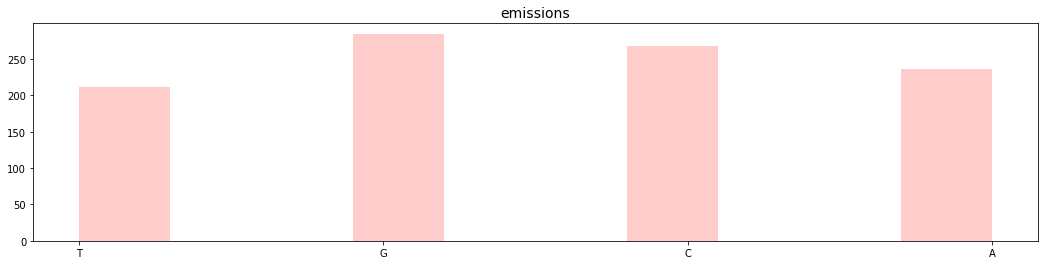

In [20]:
#displaying histogram of emissions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
ax.set_title("emissions", fontsize = 14)
ax.hist(sequence, color='r',alpha=0.2)

In [21]:
#5. Write a viterbi algorithm for finding the most likely CG regions

In [22]:
#transition probability matrix
A = np.asarray([AT_rich_t, CG_rich_t])
# AT->AT    AT->CG 
# CG->AT    CG->CG

#emission probability matrix
B = np.asarray([AT_rich_e, CG_rich_e])
# AT_A    AT_T    AT_C    AT_G    e.g AT_A = P(v=A|s=AT rich)
# CG_A    CG_T    CG_C    CG_G

#initial distribution- probability of being in hidden state pi = [p(s=AT_rich), p(s=CG_rich)]
pi = np.asarray([0.5, 0.5])

In [23]:
def viterbi(V, trans, emiss, pi):
    """the decoding problem- we need to find the most probable hidden state for every iteration of t
    theta = {trans, emiss} #model parameters
    the highest probability along a single path for first t observations which ends at state i is denoted by:
    w_i(t) = max{p(s_1,...,s_T=i,v_1,...,v_T|theta)} maximised w.r.t s_1,...,s_T-1
    w_i(t+1) = max{w_i(t)*trans_ij*emiss_jk} maximised w.r.t i
    to find the sequence of hidden states we need to identify the state that maximizes w_i(t) at each time step t
    argmax{w(t)} maximised w.r.t t
    Once we complete the above steps for all the observations, we will first find the last hidden state by maximum
    likelihood, then using backpointer to backtrack the most likely hidden path"""
    
    T = V.shape[0] #last time step
    M = trans.shape[0] #number of unknown states
 
    w = np.zeros((T,M)) #initialising w matrix containing the max joint prob of the set of
    #visible and hidden states {s_1,...,s_T,v_1,...,v_T} conditioned upon the model parameters theta
    
    if(V[0] == 'A'):
        w[0,:] = np.log(pi*emiss[:,0]) #[w_AT(0), w_CG(0)] = [max{p(s_0=AT_rich,v_0=A)}, max{p(s_0=CG_rich,v_0=A)}]
    if(V[0] == 'T'):
        w[0,:] = np.log(pi*emiss[:,1]) #[w_AT(0), w_CG(0)] = [max{p(s_0=AT_rich,v_0=T)}, max{p(s_0=CG_rich,v_0=T)}]
    if(V[0] == 'C'):
        w[0,:] = np.log(pi*emiss[:,2]) #[w_AT(0), w_CG(0)] = [max{p(s_0=AT_rich,v_0=C)}, max{p(s_0=CG_rich,v_0=C)}]
    if(V[0] == 'G'):
        w[0,:] = np.log(pi*emiss[:,3]) #[w_AT(0), w_CG(0)] = [max{p(s_0=AT_rich,v_0=G)}, max{p(s_0=CG_rich,v_0=G)}]
 
    prev = np.zeros((T-1,M)) #matrix of most probable states
 
    for t in range(1, T): #iterating through time instances
        for j in range(M): #iterating through possible values of unknown state
            if(V[t] == 'A'): #[p(s(t)=AT_rich|v(t)=A), p(s(t)=CG_rich|v(t)=A)]
                probability = w[t-1] + np.log(trans[:,j]) + np.log(emiss[j,0])
            elif(V[t] == 'T'):
                probability = w[t-1] + np.log(trans[:,j]) + np.log(emiss[j,1])
            elif(V[t] == 'C'):
                probability = w[t-1] + np.log(trans[:,j]) + np.log(emiss[j,2])
            else:
                probability = w[t-1] + np.log(trans[:,j]) + np.log(emiss[j,3])
                
            # This is our most probable state given previous state at time t
            prev[t-1,j] = np.argmax(probability)
 
            # This is the probability of the most probable state
            w[t,j] = np.max(probability)
 
    # Path Array
    S = np.zeros(T)
 
    # Find the most probable last hidden state
    last_state = np.argmax(w[T-1,:])
 
    S[0] = last_state
 
    backtrack_index = 1
    for i in range(T-2, -1, -1):
        S[backtrack_index] = prev[i, int(last_state)]
        last_state = prev[i, int(last_state)]
        backtrack_index += 1
 
    # Flip the path array since we were backtracking
    S = np.flip(S, axis=0)
 
    # Convert numeric values to actual hidden states
    result = []
    for s in S:
        if(s == 0):
            result.append("AT_rich")
        else:
            result.append("CG_rich")
 
    return result

In [24]:
def plot_result(result):
    t = [i for i in range(len(result))]
    out = []
    for i in range(len(result)):
        if(result[i]=="AT_rich"):
            out.append(0) #AT_rich
        else:
            out.append(1) #CG_rich

    fig, axes = plt.subplots(figsize=(15,4),nrows=1, ncols=1,sharex='col') # look up matplotlib documentation
    axes.plot(t,out,c='r')
    axes.set(xlabel="time instant, t", ylabel="hidden state, s")
    axes.set(title = "Graph illustrates the most likely hidden state is the CG rich region when s(t)=1")

In [25]:
result = viterbi(sequence, A, B, pi)

In [26]:
#finding t when the region changed from CG rich to AT rich
for i in range(len(result)):
    if(result[i]=="AT_rich"):
        print(i)
        break

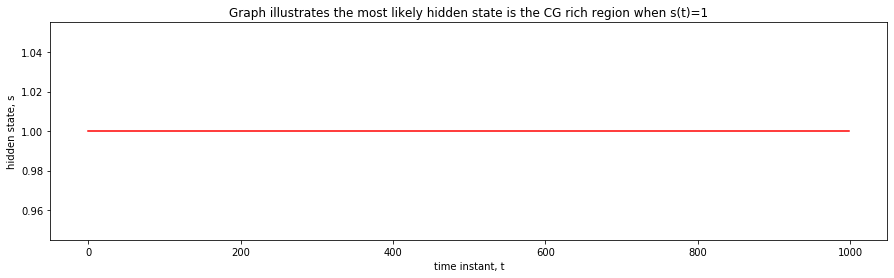

In [27]:
plot_result(result)

In [28]:
#6. Run this on the genome

In [29]:
genome ="""GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAAGGCGTTTCCGTTCTTCTTCG
TCATAACTTAATGTTTTTATTTAAAATACCCTCTGAAAAGAAAGGAAACGACAGGTGCTGAAAGCGAGGC
TTTTTGGCCTCTGTCGTTTCCTTTCTCTGTTTTTGTCCGTGGAATGAACAATGGAAGTCAACAAAAAGCA
GCTGGCTGACATTTTCGGTGCGAGTATCCGTACCATTCAGAACTGGCAGGAACAGGGAATGCCCGTTCTG
CGAGGCGGTGGCAAGGGTAATGAGGTGCTTTATGACTCTGCCGCCGTCATAAAATGGTATGCCGAAAGGG
ATGCTGAAATTGAGAACGAAAAGCTGCGCCGGGAGGTTGAAGAACTGCGGCAGGCCAGCGAGGCAGATCT
CCAGCCAGGAACTATTGAGTACGAACGCCATCGACTTACGCGTGCGCAGGCCGACGCACAGGAACTGAAG
AATGCCAGAGACTCCGCTGAAGTGGTGGAAACCGCATTCTGTACTTTCGTGCTGTCGCGGATCGCAGGTG
AAATTGCCAGTATTCTCGACGGGCTCCCCCTGTCGGTGCAGCGGCGTTTTCCGGAACTGGAAAACCGACA
TGTTGATTTCCTGAAACGGGATATCATCAAAGCCATGAACAAAGCAGCCGCGCTGGATGAACTGATACCG
GGGTTGCTGAGTGAATATATCGAACAGTCAGGTTAACAGGCTGCGGCATTTTGTCCGCGCCGGGCTTCGC
TCACTGTTCAGGCCGGAGCCACAGACCGCCGTTGAATGGGCGGATGCTAATTACTATCTCCCGAAAGAAT
CCGCATACCAGGAAGGGCGCTGGGAAACACTGCCCTTTCAGCGGGCCATCATGAATGCGATGGGCAGCGA
CTACATCCGTGAGGTGAATGTGGTGAAGTCTGCCCGTGTCGGTTATTCCAAAATGCTGCTGGGTGTTTAT
GCCTACTTTATAGAGCATAAGCAGCGCAACACCCTTATCTGGTTGCCGACGGATGGTGATGCCGAGAACT
TTATGAAAACCCACGTTGAGCCGACTATTCGTGATATTCCGTCGCTGCTGGCGCTGGCCCCGTGGTATGG
CAAAAAGCACCGGGATAACACGCTCACCATGAAGCGTTTCACTAATGGGCGTGGCTTCTGGTGCCTGGGC
GGTAAAGCGGCAAAAAACTACCGTGAAAAGTCGGTGGATGTGGCGGGTTATGATGAACTTGCTGCTTTTG
ATGATGATATTGAACAGGAAGGCTCTCCGACGTTCCTGGGTGACAAGCGTATTGAAGGCTCGGTCTGGCC
AAAGTCCATCCGTGGCTCCACGCCAAAAGTGAGAGGCACCTGTCAGATTGAGCGTGCAGCCAGTGAATCC
CCGCATTTTATGCGTTTTCATGTTGCCTGCCCGCATTGCGGGGAGGAGCAGTATCTTAAATTTGGCGACA
AAGAGACGCCGTTTGGCCTCAAATGGACGCCGGATGACCCCTCCAGCGTGTTTTATCTCTGCGAGCATAA
TGCCTGCGTCATCCGCCAGCAGGAGCTGGACTTTACTGATGCCCGTTATATCTGCGAAAAGACCGGGATC
TGGACCCGTGATGGCATTCTCTGGTTTTCGTCATCCGGTGAAGAGATTGAGCCACCTGACAGTGTGACCT
TTCACATCTGGACAGCGTACAGCCCGTTCACCACCTGGGTGCAGATTGTCAAAGACTGGATGAAAACGAA
AGGGGATACGGGAAAACGTAAAACCTTCGTAAACACCACGCTCGGTGAGACGTGGGAGGCGAAAATTGGC
GAACGTCCGGATGCTGAAGTGATGGCAGAGCGGAAAGAGCATTATTCAGCGCCCGTTCCTGACCGTGTGG
CTTACCTGACCGCCGGTATCGACTCCCAGCTGGACCGCTACGAAATGCGCGTATGGGGATGGGGGCCGGG
TGAGGAAAGCTGGCTGATTGACCGGCAGATTATTATGGGCCGCCACGACGATGAACAGACGCTGCTGCGT
GTGGATGAGGCCATCAATAAAACCTATACCCGCCGGAATGGTGCAGAAATGTCGATATCCCGTATCTGCT
GGGATACTGGCGGGATTGACCCGACCATTGTGTATGAACGCTCGAAAAAACATGGGCTGTTCCGGGTGAT
CCCCATTAAAGGGGCATCCGTCTACGGAAAGCCGGTGGCCAGCATGCCACGTAAGCGAAACAAAAACGGG
GTTTACCTTACCGAAATCGGTACGGATACCGCGAAAGAGCAGATTTATAACCGCTTCACACTGACGCCGG
AAGGGGATGAACCGCTTCCCGGTGCCGTTCACTTCCCGAATAACCCGGATATTTTTGATCTGACCGAAGC
GCAGCAGCTGACTGCTGAAGAGCAGGTCGAAAAATGGGTGGATGGCAGGAAAAAAATACTGTGGGACAGC
AAAAAGCGACGCAATGAGGCACTCGACTGCTTCGTTTATGCGCTGGCGGCGCTGCGCATCAGTATTTCCC
GCTGGCAGCTGGATCTCAGTGCGCTGCTGGCGAGCCTGCAGGAAGAGGATGGTGCAGCAACCAACAAGAA
AACACTGGCAGATTACGCCCGTGCCTTATCCGGAGAGGATGAATGACGCGACAGGAAGAACTTGCCGCTG
CCCGTGCGGCACTGCATGACCTGATGACAGGTAAACGGGTGGCAACAGTACAGAAAGACGGACGAAGGGT
GGAGTTTACGGCCACTTCCGTGTCTGACCTGAAAAAATATATTGCAGAGCTGGAAGTGCAGACCGGCATG
ACACAGCGACGCAGGGGACCTGCAGGATTTTATGTATGAAAACGCCCACCATTCCCACCCTTCTGGGGCC
GGACGGCATGACATCGCTGCGCGAATATGCCGGTTATCACGGCGGTGGCAGCGGATTTGGAGGGCAGTTG
CGGTCGTGGAACCCACCGAGTGAAAGTGTGGATGCAGCCCTGTTGCCCAACTTTACCCGTGGCAATGCCC
GCGCAGACGATCTGGTACGCAATAACGGCTATGCCGCCAACGCCATCCAGCTGCATCAGGATCATATCGT
CGGGTCTTTTTTCCGGCTCAGTCATCGCCCAAGCTGGCGCTATCTGGGCATCGGGGAGGAAGAAGCCCGT
GCCTTTTCCCGCGAGGTTGAAGCGGCATGGAAAGAGTTTGCCGAGGATGACTGCTGCTGCATTGACGTTG
AGCGAAAACGCACGTTTACCATGATGATTCGGGAAGGTGTGGCCATGCACGCCTTTAACGGTGAACTGTT
CGTTCAGGCCACCTGGGATACCAGTTCGTCGCGGCTTTTCCGGACACAGTTCCGGATGGTCAGCCCGAAG
CGCATCAGCAACCCGAACAATACCGGCGACAGCCGGAACTGCCGTGCCGGTGTGCAGATTAATGACAGCG
GTGCGGCGCTGGGATATTACGTCAGCGAGGACGGGTATCCTGGCTGGATGCCGCAGAAATGGACATGGAT
ACCCCGTGAGTTACCCGGCGGGCGCGCCTCGTTCATTCACGTTTTTGAACCCGTGGAGGACGGGCAGACT
CGCGGTGCAAATGTGTTTTACAGCGTGATGGAGCAGATGAAGATGCTCGACACGCTGCAGAACACGCAGC
TGCAGAGCGCCATTGTGAAGGCGATGTATGCCGCCACCATTGAGAGTGAGCTGGATACGCAGTCAGCGAT
GGATTTTATTCTGGGCGCGAACAGTCAGGAGCAGCGGGAAAGGCTGACCGGCTGGATTGGTGAAATTGCC
GCGTATTACGCCGCAGCGCCGGTCCGGCTGGGAGGCGCAAAAGTACCGCACCTGATGCCGGGTGACTCAC
TGAACCTGCAGACGGCTCAGGATACGGATAACGGCTACTCCGTGTTTGAGCAGTCACTGCTGCGGTATAT
CGCTGCCGGGCTGGGTGTCTCGTATGAGCAGCTTTCCCGGAATTACGCCCAGATGAGCTACTCCACGGCA
CGGGCCAGTGCGAACGAGTCGTGGGCGTACTTTATGGGGCGGCGAAAATTCGTCGCATCCCGTCAGGCGA
GCCAGATGTTTCTGTGCTGGCTGGAAGAGGCCATCGTTCGCCGCGTGGTGACGTTACCTTCAAAAGCGCG
CTTCAGTTTTCAGGAAGCCCGCAGTGCCTGGGGGAACTGCGACTGGATAGGCTCCGGTCGTATGGCCATC
GATGGTCTGAAAGAAGTTCAGGAAGCGGTGATGCTGATAGAAGCCGGACTGAGTACCTACGAGAAAGAGT
GCGCAAAACGCGGTGACGACTATCAGGAAATTTTTGCCCAGCAGGTCCGTGAAACGATGGAGCGCCGTGC
AGCCGGTCTTAAACCGCCCGCCTGGGCGGCTGCAGCATTTGAATCCGGGCTGCGACAATCAACAGAGGAG
GAGAAGAGTGACAGCAGAGCTGCGTAATCTCCCGCATATTGCCAGCATGGCCTTTAATGAGCCGCTGATG
CTTGAACCCGCCTATGCGCGGGTTTTCTTTTGTGCGCTTGCAGGCCAGCTTGGGATCAGCAGCCTGACGG
ATGCGGTGTCCGGCGACAGCCTGACTGCCCAGGAGGCACTCGCGACGCTGGCATTATCCGGTGATGATGA
CGGACCACGACAGGCCCGCAGTTATCAGGTCATGAACGGCATCGCCGTGCTGCCGGTGTCCGGCACGCTG
GTCAGCCGGACGCGGGCGCTGCAGCCGTACTCGGGGATGACCGGTTACAACGGCATTATCGCCCGTCTGC
AACAGGCTGCCAGCGATCCGATGGTGGACGGCATTCTGCTCGATATGGACACGCCCGGCGGGATGGTGGC
GGGGGCATTTGACTGCGCTGACATCATCGCCCGTGTGCGTGACATAAAACCGGTATGGGCGCTTGCCAAC
GACATGAACTGCAGTGCAGGTCAGTTGCTTGCCAGTGCCGCCTCCCGGCGTCTGGTCACGCAGACCGCCC
GGACAGGCTCCATCGGCGTCATGATGGCTCACAGTAATTACGGTGCTGCGCTGGAGAAACAGGGTGTGGA
AATCACGCTGATTTACAGCGGCAGCCATAAGGTGGATGGCAACCCCTACAGCCATCTTCCGGATGACGTC
CGGGAGACACTGCAGTCCCGGATGGACGCAACCCGCCAGATGTTTGCGCAGAAGGTGTCGGCATATACCG
GCCTGTCCGTGCAGGTTGTGCTGGATACCGAGGCTGCAGTGTACAGCGGTCAGGAGGCCATTGATGCCGG
ACTGGCTGATGAACTTGTTAACAGCACCGATGCGATCACCGTCATGCGTGATGCACTGGATGCACGTAAA
TCCCGTCTCTCAGGAGGGCGAATGACCAAAGAGACTCAATCAACAACTGTTTCAGCCACTGCTTCGCAGG
CTGACGTTACTGACGTGGTGCCAGCGACGGAGGGCGAGAACGCCAGCGCGGCGCAGCCGGACGTGAACGC
GCAGATCACCGCAGCGGTTGCGGCAGAAAACAGCCGCATTATGGGGATCCTCAACTGTGAGGAGGCTCAC
GGACGCGAAGAACAGGCACGCGTGCTGGCAGAAACCCCCGGTATGACCGTGAAAACGGCCCGCCGCATTC
TGGCCGCAGCACCACAGAGTGCACAGGCGCGCAGTGACACTGCGCTGGATCGTCTGATGCAGGGGGCACC
GGCACCGCTGGCTGCAGGTAACCCGGCATCTGATGCCGTTAACGATTTGCTGAACACACCAGTGTAAGGG
ATGTTTATGACGAGCAAAGAAACCTTTACCCATTACCAGCCGCAGGGCAACAGTGACCCGGCTCATACCG
CAACCGCGCCCGGCGGATTGAGTGCGAAAGCGCCTGCAATGACCCCGCTGATGCTGGACACCTCCAGCCG
TAAGCTGGTTGCGTGGGATGGCACCACCGACGGTGCTGCCGTTGGCATTCTTGCGGTTGCTGCTGACCAG
ACCAGCACCACGCTGACGTTCTACAAGTCCGGCACGTTCCGTTATGAGGATGTGCTCTGGCCGGAGGCTG
CCAGCGACGAGACGAAAAAACGGACCGCGTTTGCCGGAACGGCAATCAGCATCGTTTAACTTTACCCTTC
ATCACTAAAGGCCGCCTGTGCGGCTTTTTTTACGGGATTTTTTTATGTCGATGTACACAACCGCCCAACT
GCTGGCGGCAAATGAGCAGAAATTTAAGTTTGATCCGCTGTTTCTGCGTCTCTTTTTCCGTGAGAGCTAT
CCCTTCACCACGGAGAAAGTCTATCTCTCACAAATTCCGGGACTGGTAAACATGGCGCTGTACGTTTCGC
CGATTGTTTCCGGTGAGGTTATCCGTTCCCGTGGCGGCTCCACCTCTGAATTTACGCCGGGATATGTCAA
GCCGAAGCATGAAGTGAATCCGCAGATGACCCTGCGTCGCCTGCCGGATGAAGATCCGCAGAATCTGGCG
GACCCGGCTTACCGCCGCCGTCGCATCATCATGCAGAACATGCGTGACGAAGAGCTGGCCATTGCTCAGG
TCGAAGAGATGCAGGCAGTTTCTGCCGTGCTTAAGGGCAAATACACCATGACCGGTGAAGCCTTCGATCC
GGTTGAGGTGGATATGGGCCGCAGTGAGGAGAATAACATCACGCAGTCCGGCGGCACGGAGTGGAGCAAG
CGTGACAAGTCCACGTATGACCCGACCGACGATATCGAAGCCTACGCGCTGAACGCCAGCGGTGTGGTGA
ATATCATCGTGTTCGATCCGAAAGGCTGGGCGCTGTTCCGTTCCTTCAAAGCCGTCAAGGAGAAGCTGGA
TACCCGTCGTGGCTCTAATTCCGAGCTGGAGACAGCGGTGAAAGACCTGGGCAAAGCGGTGTCCTATAAG
GGGATGTATGGCGATGTGGCCATCGTCGTGTATTCCGGACAGTACGTGGAAAACGGCGTCAAAAAGAACT
TCCTGCCGGACAACACGATGGTGCTGGGGAACACTCAGGCACGCGGTCTGCGCACCTATGGCTGCATTCA
GGATGCGGACGCACAGCGCGAAGGCATTAACGCCTCTGCCCGTTACCCGAAAAACTGGGTGACCACCGGC
GATCCGGCGCGTGAGTTCACCATGATTCAGTCAGCACCGCTGATGCTGCTGGCTGACCCTGATGAGTTCG
TGTCCGTACAACTGGCGTAATCATGGCCCTTCGGGGCCATTGTTTCTCTGTGGAGGAGTCCATGACGAAA
GATGAACTGATTGCCCGTCTCCGCTCGCTGGGTGAACAACTGAACCGTGATGTCAGCCTGACGGGGACGA
AAGAAGAACTGGCGCTCCGTGTGGCAGAGCTGAAAGAGGAGCTTGATGACACGGATGAAACTGCCGGTCA
GGACACCCCTCTCAGCCGGGAAAATGTGCTGACCGGACATGAAAATGAGGTGGGATCAGCGCAGCCGGAT
ACCGTGATTCTGGATACGTCTGAACTGGTCACGGTCGTGGCACTGGTGAAGCTGCATACTGATGCACTTC
ACGCCACGCGGGATGAACCTGTGGCATTTGTGCTGCCGGGAACGGCGTTTCGTGTCTCTGCCGGTGTGGC
AGCCGAAATGACAGAGCGCGGCCTGGCCAGAATGCAATAACGGGAGGCGCTGTGGCTGATTTCGATAACC
TGTTCGATGCTGCCATTGCCCGCGCCGATGAAACGATACGCGGGTACATGGGAACGTCAGCCACCATTAC
ATCCGGTGAGCAGTCAGGTGCGGTGATACGTGGTGTTTTTGATGACCCTGAAAATATCAGCTATGCCGGA
CAGGGCGTGCGCGTTGAAGGCTCCAGCCCGTCCCTGTTTGTCCGGACTGATGAGGTGCGGCAGCTGCGGC
GTGGAGACACGCTGACCATCGGTGAGGAAAATTTCTGGGTAGATCGGGTTTCGCCGGATGATGGCGGAAG
TTGTCATCTCTGGCTTGGACGGGGCGTACCGCCTGCCGTTAACCGTCGCCGCTGAAAGGGGGATGTATGG
CCATAAAAGGTCTTGAGCAGGCCGTTGAAAACCTCAGCCGTATCAGCAAAACGGCGGTGCCTGGTGCCGC
CGCAATGGCCATTAACCGCGTTGCTTCATCCGCGATATCGCAGTCGGCGTCACAGGTTGCCCGTGAGACA
AAGGTACGCCGGAAACTGGTAAAGGAAAGGGCCAGGCTGAAAAGGGCCACGGTCAAAAATCCGCAGGCCA
GAATCAAAGTTAACCGGGGGGATTTGCCCGTAATCAAGCTGGGTAATGCGCGGGTTGTCCTTTCGCGCCG
CAGGCGTCGTAAAAAGGGGCAGCGTTCATCCCTGAAAGGTGGCGGCAGCGTGCTTGTGGTGGGTAACCGT
CGTATTCCCGGCGCGTTTATTCAGCAACTGAAAAATGGCCGGTGGCATGTCATGCAGCGTGTGGCTGGGA
AAAACCGTTACCCCATTGATGTGGTGAAAATCCCGATGGCGGTGCCGCTGACCACGGCGTTTAAACAAAA
TATTGAGCGGATACGGCGTGAACGTCTTCCGAAAGAGCTGGGCTATGCGCTGCAGCATCAACTGAGGATG
GTAATAAAGCGATGAAACATACTGAACTCCGTGCAGCCGTACTGGATGCACTGGAGAAGCATGACACCGG
GGCGACGTTTTTTGATGGTCGCCCCGCTGTTTTTGATGAGGCGGATTTTCCGGCAGTTGCCGTTTATCTC
ACCGGCGCTGAATACACGGGCGAAGAGCTGGACAGCGATACCTGGCAGGCGGAGCTGCATATCGAAGTTT
TCCTGCCTGCTCAGGTGCCGGATTCAGAGCTGGATGCGTGGATGGAGTCCCGGATTTATCCGGTGATGAG
CGATATCCCGGCACTGTCAGATTTGATCACCAGTATGGTGGCCAGCGGCTATGACTACCGGCGCGACGAT
GATGCGGGCTTGTGGAGTTCAGCCGATCTGACTTATGTCATTACCTATGAAATGTGAGGACGCTATGCCT
GTACCAAATCCTACAATGCCGGTGAAAGGTGCCGGGACCACCCTGTGGGTTTATAAGGGGAGCGGTGACC
CTTACGCGAATCCGCTTTCAGACGTTGACTGGTCGCGTCTGGCAAAAGTTAAAGACCTGACGCCCGGCGA
ACTGACCGCTGAGTCCTATGACGACAGCTATCTCGATGATGAAGATGCAGACTGGACTGCGACCGGGCAG
GGGCAGAAATCTGCCGGAGATACCAGCTTCACGCTGGCGTGGATGCCCGGAGAGCAGGGGCAGCAGGCGC
TGCTGGCGTGGTTTAATGAAGGCGATACCCGTGCCTATAAAATCCGCTTCCCGAACGGCACGGTCGATGT
GTTCCGTGGCTGGGTCAGCAGTATCGGTAAGGCGGTGACGGCGAAGGAAGTGATCACCCGCACGGTGAAA
GTCACCAATGTGGGACGTCCGTCGATGGCAGAAGATCGCAGCACGGTAACAGCGGCAACCGGCATGACCG
TGACGCCTGCCAGCACCTCGGTGGTGAAAGGGCAGAGCACCACGCTGACCGTGGCCTTCCAGCCGGAGGG
CGTAACCGACAAGAGCTTTCGTGCGGTGTCTGCGGATAAAACAAAAGCCACCGTGTCGGTCAGTGGTATG
ACCATCACCGTGAACGGCGTTGCTGCAGGCAAGGTCAACATTCCGGTTGTATCCGGTAATGGTGAGTTTG
CTGCGGTTGCAGAAATTACCGTCACCGCCAGTTAATCCGGAGAGTCAGCGATGTTCCTGAAAACCGAATC
ATTTGAACATAACGGTGTGACCGTCACGCTTTCTGAACTGTCAGCCCTGCAGCGCATTGAGCATCTCGCC
CTGATGAAACGGCAGGCAGAACAGGCGGAGTCAGACAGCAACCGGAAGTTTACTGTGGAAGACGCCATCA
GAACCGGCGCGTTTCTGGTGGCGATGTCCCTGTGGCATAACCATCCGCAGAAGACGCAGATGCCGTCCAT
GAATGAAGCCGTTAAACAGATTGAGCAGGAAGTGCTTACCACCTGGCCCACGGAGGCAATTTCTCATGCT
GAAAACGTGGTGTACCGGCTGTCTGGTATGTATGAGTTTGTGGTGAATAATGCCCCTGAACAGACAGAGG
ACGCCGGGCCCGCAGAGCCTGTTTCTGCGGGAAAGTGTTCGACGGTGAGCTGAGTTTTGCCCTGAAACTG
GCGCGTGAGATGGGGCGACCCGACTGGCGTGCCATGCTTGCCGGGATGTCATCCACGGAGTATGCCGACT
GGCACCGCTTTTACAGTACCCATTATTTTCATGATGTTCTGCTGGATATGCACTTTTCCGGGCTGACGTA
CACCGTGCTCAGCCTGTTTTTCAGCGATCCGGATATGCATCCGCTGGATTTCAGTCTGCTGAACCGGCGC
GAGGCTGACGAAGAGCCTGAAGATGATGTGCTGATGCAGAAAGCGGCAGGGCTTGCCGGAGGTGTCCGCT
TTGGCCCGGACGGGAATGAAGTTATCCCCGCTTCCCCGGATGTGGCGGACATGACGGAGGATGACGTAAT
GCTGATGACAGTATCAGAAGGGATCGCAGGAGGAGTCCGGTATGGCTGAACCGGTAGGCGATCTGGTCGT
TGATTTGAGTCTGGATGCGGCCAGATTTGACGAGCAGATGGCCAGAGTCAGGCGTCATTTTTCTGGTACG
GAAAGTGATGCGAAAAAAACAGCGGCAGTCGTTGAACAGTCGCTGAGCCGACAGGCGCTGGCTGCACAGA
AAGCGGGGATTTCCGTCGGGCAGTATAAAGCCGCCATGCGTATGCTGCCTGCACAGTTCACCGACGTGGC
CACGCAGCTTGCAGGCGGGCAAAGTCCGTGGCTGATCCTGCTGCAACAGGGGGGGCAGGTGAAGGACTCC
TTCGGCGGGATGATCCCCATGTTCAGGGGGCTTGCCGGTGCGATCACCCTGCCGATGGTGGGGGCCACCT
CGCTGGCGGTGGCGACCGGTGCGCTGGCGTATGCCTGGTATCAGGGCAACTCAACCCTGTCCGATTTCAA
CAAAACGCTGGTCCTTTCCGGCAATCAGGCGGGACTGACGGCAGATCGTATGCTGGTCCTGTCCAGAGCC
GGGCAGGCGGCAGGGCTGACGTTTAACCAGACCAGCGAGTCACTCAGCGCACTGGTTAAGGCGGGGGTAA
GCGGTGAGGCTCAGATTGCGTCCATCAGCCAGAGTGTGGCGCGTTTCTCCTCTGCATCCGGCGTGGAGGT
GGACAAGGTCGCTGAAGCCTTCGGGAAGCTGACCACAGACCCGACGTCGGGGCTGACGGCGATGGCTCGC
CAGTTCCATAACGTGTCGGCGGAGCAGATTGCGTATGTTGCTCAGTTGCAGCGTTCCGGCGATGAAGCCG
GGGCATTGCAGGCGGCGAACGAGGCCGCAACGAAAGGGTTTGATGACCAGACCCGCCGCCTGAAAGAGAA
CATGGGCACGCTGGAGACCTGGGCAGACAGGACTGCGCGGGCATTCAAATCCATGTGGGATGCGGTGCTG
GATATTGGTCGTCCTGATACCGCGCAGGAGATGCTGATTAAGGCAGAGGCTGCGTATAAGAAAGCAGACG
ACATCTGGAATCTGCGCAAGGATGATTATTTTGTTAACGATGAAGCGCGGGCGCGTTACTGGGATGATCG
TGAAAAGGCCCGTCTTGCGCTTGAAGCCGCCCGAAAGAAGGCTGAGCAGCAGACTCAACAGGACAAAAAT
GCGCAGCAGCAGAGCGATACCGAAGCGTCACGGCTGAAATATACCGAAGAGGCGCAGAAGGCTTACGAAC
GGCTGCAGACGCCGCTGGAGAAATATACCGCCCGTCAGGAAGAACTGAACAAGGCACTGAAAGACGGGAA
AATCCTGCAGGCGGATTACAACACGCTGATGGCGGCGGCGAAAAAGGATTATGAAGCGACGCTGAAAAAG
CCGAAACAGTCCAGCGTGAAGGTGTCTGCGGGCGATCGTCAGGAAGACAGTGCTCATGCTGCCCTGCTGA
CGCTTCAGGCAGAACTCCGGACGCTGGAGAAGCATGCCGGAGCAAATGAGAAAATCAGCCAGCAGCGCCG
GGATTTGTGGAAGGCGGAGAGTCAGTTCGCGGTACTGGAGGAGGCGGCGCAACGTCGCCAGCTGTCTGCA
CAGGAGAAATCCCTGCTGGCGCATAAAGATGAGACGCTGGAGTACAAACGCCAGCTGGCTGCACTTGGCG
ACAAGGTTACGTATCAGGAGCGCCTGAACGCGCTGGCGCAGCAGGCGGATAAATTCGCACAGCAGCAACG
GGCAAAACGGGCCGCCATTGATGCGAAAAGCCGGGGGCTGACTGACCGGCAGGCAGAACGGGAAGCCACG
GAACAGCGCCTGAAGGAACAGTATGGCGATAATCCGCTGGCGCTGAATAACGTCATGTCAGAGCAGAAAA
AGACCTGGGCGGCTGAAGACCAGCTTCGCGGGAACTGGATGGCAGGCCTGAAGTCCGGCTGGAGTGAGTG
GGAAGAGAGCGCCACGGACAGTATGTCGCAGGTAAAAAGTGCAGCCACGCAGACCTTTGATGGTATTGCA
CAGAATATGGCGGCGATGCTGACCGGCAGTGAGCAGAACTGGCGCAGCTTCACCCGTTCCGTGCTGTCCA
TGATGACAGAAATTCTGCTTAAGCAGGCAATGGTGGGGATTGTCGGGAGTATCGGCAGCGCCATTGGCGG
GGCTGTTGGTGGCGGCGCATCCGCGTCAGGCGGTACAGCCATTCAGGCCGCTGCGGCGAAATTCCATTTT
GCAACCGGAGGATTTACGGGAACCGGCGGCAAATATGAGCCAGCGGGGATTGTTCACCGTGGTGAGTTTG
TCTTCACGAAGGAGGCAACCAGCCGGATTGGCGTGGGGAATCTTTACCGGCTGATGCGCGGCTATGCCAC
CGGCGGTTATGTCGGTACACCGGGCAGCATGGCAGACAGCCGGTCGCAGGCGTCCGGGACGTTTGAGCAG
AATAACCATGTGGTGATTAACAACGACGGCACGAACGGGCAGATAGGTCCGGCTGCTCTGAAGGCGGTGT
ATGACATGGCCCGCAAGGGTGCCCGTGATGAAATTCAGACACAGATGCGTGATGGTGGCCTGTTCTCCGG
AGGTGGACGATGAAGACCTTCCGCTGGAAAGTGAAACCCGGTATGGATGTGGCTTCGGTCCCTTCTGTAA
GAAAGGTGCGCTTTGGTGATGGCTATTCTCAGCGAGCGCCTGCCGGGCTGAATGCCAACCTGAAAACGTA
CAGCGTGACGCTTTCTGTCCCCCGTGAGGAGGCCACGGTACTGGAGTCGTTTCTGGAAGAGCACGGGGGC
TGGAAATCCTTTCTGTGGACGCCGCCTTATGAGTGGCGGCAGATAAAGGTGACCTGCGCAAAATGGTCGT
CGCGGGTCAGTATGCTGCGTGTTGAGTTCAGCGCAGAGTTTGAACAGGTGGTGAACTGATGCAGGATATC
CGGCAGGAAACACTGAATGAATGCACCCGTGCGGAGCAGTCGGCCAGCGTGGTGCTCTGGGAAATCGACC
TGACAGAGGTCGGTGGAGAACGTTATTTTTTCTGTAATGAGCAGAACGAAAAAGGTGAGCCGGTCACCTG
GCAGGGGCGACAGTATCAGCCGTATCCCATTCAGGGGAGCGGTTTTGAACTGAATGGCAAAGGCACCAGT
ACGCGCCCCACGCTGACGGTTTCTAACCTGTACGGTATGGTCACCGGGATGGCGGAAGATATGCAGAGTC
TGGTCGGCGGAACGGTGGTCCGGCGTAAGGTTTACGCCCGTTTTCTGGATGCGGTGAACTTCGTCAACGG
AAACAGTTACGCCGATCCGGAGCAGGAGGTGATCAGCCGCTGGCGCATTGAGCAGTGCAGCGAACTGAGC
GCGGTGAGTGCCTCCTTTGTACTGTCCACGCCGACGGAAACGGATGGCGCTGTTTTTCCGGGACGTATCA
TGCTGGCCAACACCTGCACCTGGACCTATCGCGGTGACGAGTGCGGTTATAGCGGTCCGGCTGTCGCGGA
TGAATATGACCAGCCAACGTCCGATATCACGAAGGATAAATGCAGCAAATGCCTGAGCGGTTGTAAGTTC
CGCAATAACGTCGGCAACTTTGGCGGCTTCCTTTCCATTAACAAACTTTCGCAGTAAATCCCATGACACA
GACAGAATCAGCGATTCTGGCGCACGCCCGGCGATGTGCGCCAGCGGAGTCGTGCGGCTTCGTGGTAAGC
ACGCCGGAGGGGGAAAGATATTTCCCCTGCGTGAATATCTCCGGTGAGCCGGAGGCTATTTCCGTATGTC
GCCGGAAGACTGGCTGCAGGCAGAAATGCAGGGTGAGATTGTGGCGCTGGTCCACAGCCACCCCGGTGGT
CTGCCCTGGCTGAGTGAGGCCGACCGGCGGCTGCAGGTGCAGAGTGATTTGCCGTGGTGGCTGGTCTGCC
GGGGGACGATTCATAAGTTCCGCTGTGTGCCGCATCTCACCGGGCGGCGCTTTGAGCACGGTGTGACGGA
CTGTTACACACTGTTCCGGGATGCTTATCATCTGGCGGGGATTGAGATGCCGGACTTTCATCGTGAGGAT
GACTGGTGGCGTAACGGCCAGAATCTCTATCTGGATAATCTGGAGGCGACGGGGCTGTATCAGGTGCCGT
TGTCAGCGGCACAGCCGGGCGATGTGCTGCTGTGCTGTTTTGGTTCATCAGTGCCGAATCACGCCGCAAT
TTACTGCGGCGACGGCGAGCTGCTGCACCATATTCCTGAACAACTGAGCAAACGAGAGAGGTACACCGAC
AAATGGCAGCGACGCACACACTCCCTCTGGCGTCACCGGGCATGGCGCGCATCTGCCTTTACGGGGATTT
ACAACGATTTGGTCGCCGCATCGACCTTCGTGTGAAAACGGGGGCTGAAGCCATCCGGGCACTGGCCACA
CAGCTCCCGGCGTTTCGTCAGAAACTGAGCGACGGCTGGTATCAGGTACGGATTGCCGGGCGGGACGTCA
GCACGTCCGGGTTAACGGCGCAGTTACATGAGACTCTGCCTGATGGCGCTGTAATTCATATTGTTCCCAG
AGTCGCCGGGGCCAAGTCAGGTGGCGTATTCCAGATTGTCCTGGGGGCTGCCGCCATTGCCGGATCATTC
TTTACCGCCGGAGCCACCCTTGCAGCATGGGGGGCAGCCATTGGGGCCGGTGGTATGACCGGCATCCTGT
TTTCTCTCGGTGCCAGTATGGTGCTCGGTGGTGTGGCGCAGATGCTGGCACCGAAAGCCAGAACTCCCCG
TATACAGACAACGGATAACGGTAAGCAGAACACCTATTTCTCCTCACTGGATAACATGGTTGCCCAGGGC
AATGTTCTGCCTGTTCTGTACGGGGAAATGCGCGTGGGGTCACGCGTGGTTTCTCAGGAGATCAGCACGG
CAGACGAAGGGGACGGTGGTCAGGTTGTGGTGATTGGTCGCTGATGCAAAATGTTTTATGTGAAACCGCC
TGCGGGCGGTTTTGTCATTTATGGAGCGTGAGGAATGGGTAAAGGAAGCAGTAAGGGGCATACCCCGCGC
GAAGCGAAGGACAACCTGAAGTCCACGCAGTTGCTGAGTGTGATCGATGCCATCAGCGAAGGGCCGATTG
AAGGTCCGGTGGATGGCTTAAAAAGCGTGCTGCTGAACAGTACGCCGGTGCTGGACACTGAGGGGAATAC
CAACATATCCGGTGTCACGGTGGTGTTCCGGGCTGGTGAGCAGGAGCAGACTCCGCCGGAGGGATTTGAA
TCCTCCGGCTCCGAGACGGTGCTGGGTACGGAAGTGAAATATGACACGCCGATCACCCGCACCATTACGT
CTGCAAACATCGACCGTCTGCGCTTTACCTTCGGTGTACAGGCACTGGTGGAAACCACCTCAAAGGGTGA
CAGGAATCCGTCGGAAGTCCGCCTGCTGGTTCAGATACAACGTAACGGTGGCTGGGTGACGGAAAAAGAC
ATCACCATTAAGGGCAAAACCACCTCGCAGTATCTGGCCTCGGTGGTGATGGGTAACCTGCCGCCGCGCC
CGTTTAATATCCGGATGCGCAGGATGACGCCGGACAGCACCACAGACCAGCTGCAGAACAAAACGCTCTG
GTCGTCATACACTGAAATCATCGATGTGAAACAGTGCTACCCGAACACGGCACTGGTCGGCGTGCAGGTG
GACTCGGAGCAGTTCGGCAGCCAGCAGGTGAGCCGTAATTATCATCTGCGCGGGCGTATTCTGCAGGTGC
CGTCGAACTATAACCCGCAGACGCGGCAATACAGCGGTATCTGGGACGGAACGTTTAAACCGGCATACAG
CAACAACATGGCCTGGTGTCTGTGGGATATGCTGACCCATCCGCGCTACGGCATGGGGAAACGTCTTGGT
GCGGCGGATGTGGATAAATGGGCGCTGTATGTCATCGGCCAGTACTGCGACCAGTCAGTGCCGGACGGCT
TTGGCGGCACGGAGCCGCGCATCACCTGTAATGCGTACCTGACCACACAGCGTAAGGCGTGGGATGTGCT
CAGCGATTTCTGCTCGGCGATGCGCTGTATGCCGGTATGGAACGGGCAGACGCTGACGTTCGTGCAGGAC
CGACCGTCGGATAAGACGTGGACCTATAACCGCAGTAATGTGGTGATGCCGGATGATGGCGCGCCGTTCC
GCTACAGCTTCAGCGCCCTGAAGGACCGCCATAATGCCGTTGAGGTGAACTGGATTGACCCGAACAACGG
CTGGGAGACGGCGACAGAGCTTGTTGAAGATACGCAGGCCATTGCCCGTTACGGTCGTAATGTTACGAAG
ATGGATGCCTTTGGCTGTACCAGCCGGGGGCAGGCACACCGCGCCGGGCTGTGGCTGATTAAAACAGAAC
TGCTGGAAACGCAGACCGTGGATTTCAGCGTCGGCGCAGAAGGGCTTCGCCATGTACCGGGCGATGTTAT
TGAAATCTGCGATGATGACTATGCCGGTATCAGCACCGGTGGTCGTGTGCTGGCGGTGAACAGCCAGACC
CGGACGCTGACGCTCGACCGTGAAATCACGCTGCCATCCTCCGGTACCGCGCTGATAAGCCTGGTTGACG
GAAGTGGCAATCCGGTCAGCGTGGAGGTTCAGTCCGTCACCGACGGCGTGAAGGTAAAAGTGAGCCGTGT
TCCTGACGGTGTTGCTGAATACAGCGTATGGGAGCTGAAGCTGCCGACGCTGCGCCAGCGACTGTTCCGC
TGCGTGAGTATCCGTGAGAACGACGACGGCACGTATGCCATCACCGCCGTGCAGCATGTGCCGGAAAAAG
AGGCCATCGTGGATAACGGGGCGCACTTTGACGGCGAACAGAGTGGCACGGTGAATGGTGTCACGCCGCC
AGCGGTGCAGCACCTGACCGCAGAAGTCACTGCAGACAGCGGGGAATATCAGGTGCTGGCGCGATGGGAC
ACACCGAAGGTGGTGAAGGGCGTGAGTTTCCTGCTCCGTCTGACCGTAACAGCGGACGACGGCAGTGAGC
GGCTGGTCAGCACGGCCCGGACGACGGAAACCACATACCGCTTCACGCAACTGGCGCTGGGGAACTACAG
GCTGACAGTCCGGGCGGTAAATGCGTGGGGGCAGCAGGGCGATCCGGCGTCGGTATCGTTCCGGATTGCC
GCACCGGCAGCACCGTCGAGGATTGAGCTGACGCCGGGCTATTTTCAGATAACCGCCACGCCGCATCTTG
CCGTTTATGACCCGACGGTACAGTTTGAGTTCTGGTTCTCGGAAAAGCAGATTGCGGATATCAGACAGGT
TGAAACCAGCACGCGTTATCTTGGTACGGCGCTGTACTGGATAGCCGCCAGTATCAATATCAAACCGGGC
CATGATTATTACTTTTATATCCGCAGTGTGAACACCGTTGGCAAATCGGCATTCGTGGAGGCCGTCGGTC
GGGCGAGCGATGATGCGGAAGGTTACCTGGATTTTTTCAAAGGCAAGATAACCGAATCCCATCTCGGCAA
GGAGCTGCTGGAAAAAGTCGAGCTGACGGAGGATAACGCCAGCAGACTGGAGGAGTTTTCGAAAGAGTGG
AAGGATGCCAGTGATAAGTGGAATGCCATGTGGGCTGTCAAAATTGAGCAGACCAAAGACGGCAAACATT
ATGTCGCGGGTATTGGCCTCAGCATGGAGGACACGGAGGAAGGCAAACTGAGCCAGTTTCTGGTTGCCGC
CAATCGTATCGCATTTATTGACCCGGCAAACGGGAATGAAACGCCGATGTTTGTGGCGCAGGGCAACCAG
ATATTCATGAACGACGTGTTCCTGAAGCGCCTGACGGCCCCCACCATTACCAGCGGCGGCAATCCTCCGG
CCTTTTCCCTGACACCGGACGGAAAGCTGACCGCTAAAAATGCGGATATCAGTGGCAGTGTGAATGCGAA
CTCCGGGACGCTCAGTAATGTGACGATAGCTGAAAACTGTACGATAAACGGTACGCTGAGGGCGGAAAAA
ATCGTCGGGGACATTGTAAAGGCGGCGAGCGCGGCTTTTCCGCGCCAGCGTGAAAGCAGTGTGGACTGGC
CGTCAGGTACCCGTACTGTCACCGTGACCGATGACCATCCTTTTGATCGCCAGATAGTGGTGCTTCCGCT
GACGTTTCGCGGAAGTAAGCGTACTGTCAGCGGCAGGACAACGTATTCGATGTGTTATCTGAAAGTACTG
ATGAACGGTGCGGTGATTTATGATGGCGCGGCGAACGAGGCGGTACAGGTGTTCTCCCGTATTGTTGACA
TGCCAGCGGGTCGGGGAAACGTGATCCTGACGTTCACGCTTACGTCCACACGGCATTCGGCAGATATTCC
GCCGTATACGTTTGCCAGCGATGTGCAGGTTATGGTGATTAAGAAACAGGCGCTGGGCATCAGCGTGGTC
TGAGTGTGTTACAGAGGTTCGTCCGGGAACGGGCGTTTTATTATAAAACAGTGAGAGGTGAACGATGCGT
AATGTGTGTATTGCCGTTGCTGTCTTTGCCGCACTTGCGGTGACAGTCACTCCGGCCCGTGCGGAAGGTG
GACATGGTACGTTTACGGTGGGCTATTTTCAAGTGAAACCGGGTACATTGCCGTCGTTGTCGGGCGGGGA
TACCGGTGTGAGTCATCTGAAAGGGATTAACGTGAAGTACCGTTATGAGCTGACGGACAGTGTGGGGGTG
ATGGCTTCCCTGGGGTTCGCCGCGTCGAAAAAGAGCAGCACAGTGATGACCGGGGAGGATACGTTTCACT
ATGAGAGCCTGCGTGGACGTTATGTGAGCGTGATGGCCGGACCGGTTTTACAAATCAGTAAGCAGGTCAG
TGCGTACGCCATGGCCGGAGTGGCTCACAGTCGGTGGTCCGGCAGTACAATGGATTACCGTAAGACGGAA
ATCACTCCCGGGTATATGAAAGAGACGACCACTGCCAGGGACGAAAGTGCAATGCGGCATACCTCAGTGG
CGTGGAGTGCAGGTATACAGATTAATCCGGCAGCGTCCGTCGTTGTTGATATTGCTTATGAAGGCTCCGG
CAGTGGCGACTGGCGTACTGACGGATTCATCGTTGGGGTCGGTTATAAATTCTGATTAGCCAGGTAACAC
AGTGTTATGACAGCCCGCCGGAACCGGTGGGCTTTTTTGTGGGGTGAATATGGCAGTAAAGATTTCAGGA
GTCCTGAAAGACGGCACAGGAAAACCGGTACAGAACTGCACCATTCAGCTGAAAGCCAGACGTAACAGCA
CCACGGTGGTGGTGAACACGGTGGGCTCAGAGAATCCGGATGAAGCCGGGCGTTACAGCATGGATGTGGA
GTACGGTCAGTACAGTGTCATCCTGCAGGTTGACGGTTTTCCACCATCGCACGCCGGGACCATCACCGTG
TATGAAGATTCACAACCGGGGACGCTGAATGATTTTCTCTGTGCCATGACGGAGGATGATGCCCGGCCGG
AGGTGCTGCGTCGTCTTGAACTGATGGTGGAAGAGGTGGCGCGTAACGCGTCCGTGGTGGCACAGAGTAC
GGCAGACGCGAAGAAATCAGCCGGCGATGCCAGTGCATCAGCTGCTCAGGTCGCGGCCCTTGTGACTGAT
GCAACTGACTCAGCACGCGCCGCCAGCACGTCCGCCGGACAGGCTGCATCGTCAGCTCAGGAAGCGTCCT
CCGGCGCAGAAGCGGCATCAGCAAAGGCCACTGAAGCGGAAAAAAGTGCCGCAGCCGCAGAGTCCTCAAA
AAACGCGGCGGCCACCAGTGCCGGTGCGGCGAAAACGTCAGAAACGAATGCTGCAGCGTCACAACAATCA
GCCGCCACGTCTGCCTCCACCGCGGCCACGAAAGCGTCAGAGGCCGCCACTTCAGCACGAGATGCGGTGG
CCTCAAAAGAGGCAGCAAAATCATCAGAAACGAACGCATCATCAAGTGCCGGTCGTGCAGCTTCCTCGGC
AACGGCGGCAGAAAATTCTGCCAGGGCGGCAAAAACGTCCGAGACGAATGCCAGGTCATCTGAAACAGCA
GCGGAACGGAGCGCCTCTGCCGCGGCAGACGCAAAAACAGCGGCGGCGGGGAGTGCGTCAACGGCATCCA
CGAAGGCGACAGAGGCTGCGGGAAGTGCGGTATCAGCATCGCAGAGCAAAAGTGCGGCAGAAGCGGCGGC
AATACGTGCAAAAAATTCGGCAAAACGTGCAGAAGATATAGCTTCAGCTGTCGCGCTTGAGGATGCGGAC
ACAACGAGAAAGGGGATAGTGCAGCTCAGCAGTGCAACCAACAGCACGTCTGAAACGCTTGCTGCAACGC
CAAAGGCGGTTAAGGTGGTAATGGATGAAACGAACAGAAAAGCCCACTGGACAGTCCGGCACTGACCGGA
ACGCCAACAGCACCAACCGCGCTCAGGGGAACAAACAATACCCAGATTGCGAACACCGCTTTTGTACTGG
CCGCGATTGCAGATGTTATCGACGCGTCACCTGACGCACTGAATACGCTGAATGAACTGGCCGCAGCGCT
CGGGAATGATCCAGATTTTGCTACCACCATGACTAACGCGCTTGCGGGTAAACAACCGAAGAATGCGACA
CTGACGGCGCTGGCAGGGCTTTCCACGGCGAAAAATAAATTACCGTATTTTGCGGAAAATGATGCCGCCA
GCCTGACTGAACTGACTCAGGTTGGCAGGGATATTCTGGCAAAAAATTCCGTTGCAGATGTTCTTGAATA
CCTTGGGGCCGGTGAGAATTCGGCCTTTCCGGCAGGTGCGCCGATCCCGTGGCCATCAGATATCGTTCCG
TCTGGCTACGTCCTGATGCAGGGGCAGGCGTTTGACAAATCAGCCTACCCAAAACTTGCTGTCGCGTATC
CATCGGGTGTGCTTCCTGATATGCGAGGCTGGACAATCAAGGGGAAACCCGCCAGCGGTCGTGCTGTATT
GTCTCAGGAACAGGATGGAATTAAGTCGCACACCCACAGTGCCAGTGCATCCGGTACGGATTTGGGGACG
AAAACCACATCGTCGTTTGATTACGGGACGAAAACAACAGGCAGTTTCGATTACGGCACCAAATCGACGA
ATAACACGGGGGCTCATGCTCACAGTCTGAGCGGTTCAACAGGGGCCGCGGGTGCTCATGCCCACACAAG
TGGTTTAAGGATGAACAGTTCTGGCTGGAGTCAGTATGGAACAGCAACCATTACAGGAAGTTTATCCACA
GTTAAAGGAACCAGCACACAGGGTATTGCTTATTTATCGAAAACGGACAGTCAGGGCAGCCACAGTCACT
CATTGTCCGGTACAGCCGTGAGTGCCGGTGCACATGCGCATACAGTTGGTATTGGTGCGCACCAGCATCC
GGTTGTTATCGGTGCTCATGCCCATTCTTTCAGTATTGGTTCACACGGACACACCATCACCGTTAACGCT
GCGGGTAACGCGGAAAACACCGTCAAAAACATTGCATTTAACTATATTGTGAGGCTTGCATAATGGCATT
CAGAATGAGTGAACAACCACGGACCATAAAAATTTATAATCTGCTGGCCGGAACTAATGAATTTATTGGT
GAAGGTGACGCATATATTCCGCCTCATACCGGTCTGCCTGCAAACAGTACCGATATTGCACCGCCAGATA
TTCCGGCTGGCTTTGTGGCTGTTTTCAACAGTGATGAGGCATCGTGGCATCTCGTTGAAGACCATCGGGG
TAAAACCGTCTATGACGTGGCTTCCGGCGACGCGTTATTTATTTCTGAACTCGGTCCGTTACCGGAAAAT
TTTACCTGGTTATCGCCGGGAGGGGAATATCAGAAGTGGAACGGCACAGCCTGGGTGAAGGATACGGAAG
CAGAAAAACTGTTCCGGATCCGGGAGGCGGAAGAAACAAAAAAAAGCCTGATGCAGGTAGCCAGTGAGCA
TATTGCGCCGCTTCAGGATGCTGCAGATCTGGAAATTGCAACGAAGGAAGAAACCTCGTTGCTGGAAGCC
TGGAAGAAGTATCGGGTGTTGCTGAACCGTGTTGATACATCAACTGCACCTGATATTGAGTGGCCTGCTG
TCCCTGTTATGGAGTAATCGTTTTGTGATATGCCGCAGAAACGTTGTATGAAATAACGTTCTGCGGTTAG
TTAGTATATTGTAAAGCTGAGTATTGGTTTATTTGGCGATTATTATCTTCAGGAGAATAATGGAAGTTCT
ATGACTCAATTGTTCATAGTGTTTACATCACCGCCAATTGCTTTTAAGACTGAACGCATGAAATATGGTT
TTTCGTCATGTTTTGAGTCTGCTGTTGATATTTCTAAAGTCGGTTTTTTTTCTTCGTTTTCTCTAACTAT
TTTCCATGAAATACATTTTTGATTATTATTTGAATCAATTCCAATTACCTGAAGTCTTTCATCTATAATT
GGCATTGTATGTATTGGTTTATTGGAGTAGATGCTTGCTTTTCTGAGCCATAGCTCTGATATCCAAATGA
AGCCATAGGCATTTGTTATTTTGGCTCTGTCAGCTGCATAACGCCAAAAAATATATTTATCTGCTTGATC
TTCAAATGTTGTATTGATTAAATCAATTGGATGGAATTGTTTATCATAAAAAATTAATGTTTGAATGTGA
TAACCGTCCTTTAAAAAAGTCGTTTCTGCAAGCTTGGCTGTATAGTCAACTAACTCTTCTGTCGAAGTGA
TATTTTTAGGCTTATCTACCAGTTTTAGACGCTCTTTAATATCTTCAGGAATTATTTTATTGTCATATTG
TATCATGCTAAATGACAATTTGCTTATGGAGTAATCTTTTAATTTTAAATAAGTTATTCTCCTGGCTTCA
TCAAATAAAGAGTCGAATGATGTTGGCGAAATCACATCGTCACCCATTGGATTGTTTATTTGTATGCCAA
GAGAGTTACAGCAGTTATACATTCTGCCATAGATTATAGCTAAGGCATGTAATAATTCGTAATCTTTTAG
CGTATTAGCGACCCATCGTCTTTCTGATTTAATAATAGATGATTCAGTTAAATATGAAGGTAATTTCTTT
TGTGCAAGTCTGACTAACTTTTTTATACCAATGTTTAACATACTTTCATTTGTAATAAACTCAATGTCAT
TTTCTTCAATGTAAGATGAAATAAGAGTAGCCTTTGCCTCGCTATACATTTCTAAATCGCCTTGTTTTTC
TATCGTATTGCGAGAATTTTTAGCCCAAGCCATTAATGGATCATTTTTCCATTTTTCAATAACATTATTG
TTATACCAAATGTCATATCCTATAATCTGGTTTTTGTTTTTTTGAATAATAAATGTTACTGTTCTTGCGG
TTTGGAGGAATTGATTCAAATTCAAGCGAAATAATTCAGGGTCAAAATATGTATCAATGCAGCATTTGAG
CAAGTGCGATAAATCTTTAAGTCTTCTTTCCCATGGTTTTTTAGTCATAAAACTCTCCATTTTGATAGGT
TGCATGCTAGATGCTGATATATTTTAGAGGTGATAAAATTAACTGCTTAACTGTCAATGTAATACAAGTT
GTTTGATCTTTGCAATGATTCTTATCAGAAACCATATAGTAAATTAGTTACACAGGAAATTTTTAATATT
ATTATTATCATTCATTATGTATTAAAATTAGAGTTGTGGCTTGGCTCTGCTAACACGTTGCTCATAGGAG
ATATGGTAGAGCCGCAGACACGTCGTATGCAGGAACGTGCTGCGGCTGGCTGGTGAACTTCCGATAGTGC
GGGTGTTGAATGATTTCCAGTTGCTACCGATTTTACATATTTTTTGCATGAGAGAATTTGTACCACCTCC
CACCGACCATCTATGACTGTACGCCACTGTCCCTAGGACTGCTATGTGCCGGAGCGGACATTACAAACGT
CCTTCTCGGTGCATGCCACTGTTGCCAATGACCTGCCTAGGAATTGGTTAGCAAGTTACTACCGGATTTT
GTAAAAACAGCCCTCCTCATATAAAAAGTATTCGTTCACTTCCGATAAGCGTCGTAATTTTCTATCTTTC
ATCATATTCTAGATCCCTCTGAAAAAATCTTCCGAGTTTGCTAGGCACTGATACATAACTCTTTTCCAAT
AATTGGGGAAGTCATTCAAATCTATAATAGGTTTCAGATTTGCTTCAATAAATTCTGACTGTAGCTGCTG
AAACGTTGCGGTTGAACTATATTTCCTTATAACTTTTACGAAAGAGTTTCTTTGAGTAATCACTTCACTC
AAGTGCTTCCCTGCCTCCAAACGATACCTGTTAGCAATATTTAATAGCTTGAAATGATGAAGAGCTCTGT
GTTTGTCTTCCTGCCTCCAGTTCGCCGGGCATTCAACATAAAAACTGATAGCACCCGGAGTTCCGGAAAC
GAAATTTGCATATACCCATTGCTCACGAAAAAAAATGTCCTTGTCGATATAGGGATGAATCGCTTGGTGT
ACCTCATCTACTGCGAAAACTTGACCTTTCTCTCCCATATTGCAGTCGCGGCACGATGGAACTAAATTAA
TAGGCATCACCGAAAATTCAGGATAATGTGCAATAGGAAGAAAATGATCTATATTTTTTGTCTGTCCTAT
ATCACCACAAAATGGACATTTTTCACCTGATGAAACAAGCATGTCATCGTAATATGTTCTAGCGGGTTTG
TTTTTATCTCGGAGATTATTTTCATAAAGCTTTTCTAATTTAACCTTTGTCAGGTTACCAACTACTAAGG
TTGTAGGCTCAAGAGGGTGTGTCCTGTCGTAGGTAAATAACTGACCTGTCGAGCTTAATATTCTATATTG
TTGTTCTTTCTGCAAAAAAGTGGGGAAGTGAGTAATGAAATTATTTCTAACATTTATCTGCATCATACCT
TCCGAGCATTTATTAAGCATTTCGCTATAAGTTCTCGCTGGAAGAGGTAGTTTTTTCATTGTACTTTACC
TTCATCTCTGTTCATTATCATCGCTTTTAAAACGGTTCGACCTTCTAATCCTATCTGACCATTATAATTT
TTTAGAATGGTTTCATAAGAAAGCTCTGAATCAACGGACTGCGATAATAAGTGGTGGTATCCAGAATTTG
TCACTTCAAGTAAAAACACCTCACGAGTTAAAACACCTAAGTTCTCACCGAATGTCTCAATATCCGGACG
GATAATATTTATTGCTTCTCTTGACCGTAGGACTTTCCACATGCAGGATTTTGGAACCTCTTGCAGTACT
ACTGGGGAATGAGTTGCAATTATTGCTACACCATTGCGTGCATCGAGTAAGTCGCTTAATGTTCGTAAAA
AAGCAGAGAGCAAAGGTGGATGCAGATGAACCTCTGGTTCATCGAATAAAACTAATGACTTTTCGCCAAC
GACATCTACTAATCTTGTGATAGTAAATAAAACAATTGCATGTCCAGAGCTCATTCGAAGCAGATATTTC
TGGATATTGTCATAAAACAATTTAGTGAATTTATCATCGTCCACTTGAATCTGTGGTTCATTACGTCTTA
ACTCTTCATATTTAGAAATGAGGCTGATGAGTTCCATATTTGAAAAGTTTTCATCACTACTTAGTTTTTT
GATAGCTTCAAGCCAGAGTTGTCTTTTTCTATCTACTCTCATACAACCAATAAATGCTGAAATGAATTCT
AAGCGGAGATCGCCTAGTGATTTTAAACTATTGCTGGCAGCATTCTTGAGTCCAATATAAAAGTATTGTG
TACCTTTTGCTGGGTCAGGTTGTTCTTTAGGAGGAGTAAAAGGATCAAATGCACTAAACGAAACTGAAAC
AAGCGATCGAAAATATCCCTTTGGGATTCTTGACTCGATAAGTCTATTATTTTCAGAGAAAAAATATTCA
TTGTTTTCTGGGTTGGTGATTGCACCAATCATTCCATTCAAAATTGTTGTTTTACCACACCCATTCCGCC
CGATAAAAGCATGAATGTTCGTGCTGGGCATAGAATTAACCGTCACCTCAAAAGGTATAGTTAAATCACT
GAATCCGGGAGCACTTTTTCTATTAAATGAAAAGTGGAAATCTGACAATTCTGGCAAACCATTTAACACA
CGTGCGAACTGTCCATGAATTTCTGAAAGAGTTACCCCTCTAAGTAATGAGGTGTTAAGGACGCTTTCAT
TTTCAATGTCGGCTAATCGATTTGGCCATACTACTAAATCCTGAATAGCTTTAAGAAGGTTATGTTTAAA
ACCATCGCTTAATTTGCTGAGATTAACATAGTAGTCAATGCTTTCACCTAAGGAAAAAAACATTTCAGGG
AGTTGACTGAATTTTTTATCTATTAATGAATAAGTGCTTACTTCTTCTTTTTGACCTACAAAACCAATTT
TAACATTTCCGATATCGCATTTTTCACCATGCTCATCAAAGACAGTAAGATAAAACATTGTAACAAAGGA
ATAGTCATTCCAACCATCTGCTCGTAGGAATGCCTTATTTTTTTCTACTGCAGGAATATACCCGCCTCTT
TCAATAACACTAAACTCCAACATATAGTAACCCTTAATTTTATTAAAATAACCGCAATTTATTTGGCGGC
AACACAGGATCTCTCTTTTAAGTTACTCTCTATTACATACGTTTTCCATCTAAAAATTAGTAGTATTGAA
CTTAACGGGGCATCGTATTGTAGTTTTCCATATTTAGCTTTCTGCTTCCTTTTGGATAACCCACTGTTAT
TCATGTTGCATGGTGCACTGTTTATACCAACGATATAGTCTATTAATGCATATATAGTATCGCCGAACGA
TTAGCTCTTCAGGCTTCTGAAGAAGCGTTTCAAGTACTAATAAGCCGATAGATAGCCACGGACTTCGTAG
CCATTTTTCATAAGTGTTAACTTCCGCTCCTCGCTCATAACAGACATTCACTACAGTTATGGCGGAAAGG
TATGCATGCTGGGTGTGGGGAAGTCGTGAAAGAAAAGAAGTCAGCTGCGTCGTTTGACATCACTGCTATC
TTCTTACTGGTTATGCAGGTCGTAGTGGGTGGCACACAAAGCTTTGCACTGGATTGCGAGGCTTTGTGCT
TCTCTGGAGTGCGACAGGTTTGATGACAAAAAATTAGCGCAAGAAGACAAAAATCACCTTGCGCTAATGC
TCTGTTACAGGTCACTAATACCATCTAAGTAGTTGATTCATAGTGACTGCATATGTTGTGTTTTACAGTA
TTATGTAGTCTGTTTTTTATGCAAAATCTAATTTAATATATTGATATTTATATCATTTTACGTTTCTCGT
TCAGCTTTTTTATACTAAGTTGGCATTATAAAAAAGCATTGCTTATCAATTTGTTGCAACGAACAGGTCA
CTATCAGTCAAAATAAAATCATTATTTGATTTCAATTTTGTCCCACTCCCTGCCTCTGTCATCACGATAC
TGTGATGCCATGGTGTCCGACTTATGCCCGAGAAGATGTTGAGCAAACTTATCGCTTATCTGCTTCTCAT
AGAGTCTTGCAGACAAACTGCGCAACTCGTGAAAGGTAGGCGGATCCCCTTCGAAGGAAAGACCTGATGC
TTTTCGTGCGCGCATAAAATACCTTGATACTGTGCCGGATGAAAGCGGTTCGCGACGAGTAGATGCAATT
ATGGTTTCTCCGCCAAGAATCTCTTTGCATTTATCAAGTGTTTCCTTCATTGATATTCCGAGAGCATCAA
TATGCAATGCTGTTGGGATGGCAATTTTTACGCCTGTTTTGCTTTGCTCGACATAAAGATATCCATCTAC
GATATCAGACCACTTCATTTCGCATAAATCACCAACTCGTTGCCCGGTAACAACAGCCAGTTCCATTGCA
AGTCTGAGCCAACATGGTGATGATTCTGCTGCTTGATAAATTTTCAGGTATTCGTCAGCCGTAAGTCTTG
ATCTCCTTACCTCTGATTTTGCTGCGCGAGTGGCAGCGACATGGTTTGTTGTTATATGGCCTTCAGCTAT
TGCCTCTCGGAATGCATCGCTCAGTGTTGATCTGATTAACTTGGCTGACGCCGCCTTGCCCTCGTCTATG
TATCCATTGAGCATTGCCGCAATTTCTTTTGTGGTGATGTCTTCAAGTGGAGCATCAGGCAGACCCCTCC
TTATTGCTTTAATTTTGCTCATGTAATTTATGAGTGTCTTCTGCTTGATTCCTCTGCTGGCCAGGATTTT
TTCGTAGCGATCAAGCCATGAATGTAACGTAACGGAATTATCACTGTTGATTCTCGCTGTCAGAGGCTTG
TGTTTGTGTCCTGAAAATAACTCAATGTTGGCCTGTATAGCTTCAGTGATTGCGATTCGCCTGTCTCTGC
CTAATCCAAACTCTTTACCCGTCCTTGGGTCCCTGTAGCAGTAATATCCATTGTTTCTTATATAAAGGTT
AGGGGGTAAATCCCGGCGCTCATGACTTCGCCTTCTTCCCATTTCTGATCCTCTTCAAAAGGCCACCTGT
TACTGGTCGATTTAAGTCAACCTTTACCGCTGATTCGTGGAACAGATACTCTCTTCCATCCTTAACCGGA
GGTGGGAATATCCTGCATTCCCGAACCCATCGACGAACTGTTTCAAGGCTTCTTGGACGTCGCTGGCGTG
CGTTCCACTCCTGAAGTGTCAAGTACATCGCAAAGTCTCCGCAATTACACGCAAGAAAAAACCGCCATCA
GGCGGCTTGGTGTTCTTTCAGTTCTTCAATTCGAATATTGGTTACGTCTGCATGTGCTATCTGCGCCCAT
ATCATCCAGTGGTCGTAGCAGTCGTTGATGTTCTCCGCTTCGATAACTCTGTTGAATGGCTCTCCATTCC
ATTCTCCTGTGACTCGGAAGTGCATTTATCATCTCCATAAAACAAAACCCGCCGTAGCGAGTTCAGATAA
AATAAATCCCCGCGAGTGCGAGGATTGTTATGTAATATTGGGTTTAATCATCTATATGTTTTGTACAGAG
AGGGCAAGTATCGTTTCCACCGTACTCGTGATAATAATTTTGCACGGTATCAGTCATTTCTCGCACATTG
CAGAATGGGGATTTGTCTTCATTAGACTTATAAACCTTCATGGAATATTTGTATGCCGACTCTATATCTA
TACCTTCATCTACATAAACACCTTCGTGATGTCTGCATGGAGACAAGACACCGGATCTGCACAACATTGA
TAACGCCCAATCTTTTTGCTCAGACTCTAACTCATTGATACTCATTTATAAACTCCTTGCAATGTATGTC
GTTTCAGCTAAACGGTATCAGCAATGTTTATGTAAAGAAACAGTAAGATAATACTCAACCCGATGTTTGA
GTACGGTCATCATCTGACACTACAGACTCTGGCATCGCTGTGAAGACGACGCGAAATTCAGCATTTTCAC
AAGCGTTATCTTTTACAAAACCGATCTCACTCTCCTTTGATGCGAATGCCAGCGTCAGACATCATATGCA
GATACTCACCTGCATCCTGAACCCATTGACCTCCAACCCCGTAATAGCGATGCGTAATGATGTCGATAGT
TACTAACGGGTCTTGTTCGATTAACTGCCGCAGAAACTCTTCCAGGTCACCAGTGCAGTGCTTGATAACA
GGAGTCTTCCCAGGATGGCGAACAACAAGAAACTGGTTTCCGTCTTCACGGACTTCGTTGCTTTCCAGTT
TAGCAATACGCTTACTCCCATCCGAGATAACACCTTCGTAATACTCACGCTGCTCGTTGAGTTTTGATTT
TGCTGTTTCAAGCTCAACACGCAGTTTCCCTACTGTTAGCGCAATATCCTCGTTCTCCTGGTCGCGGCGT
TTGATGTATTGCTGGTTTCTTTCCCGTTCATCCAGCAGTTCCAGCACAATCGATGGTGTTACCAATTCAT
GGAAAAGGTCTGCGTCAAATCCCCAGTCGTCATGCATTGCCTGCTCTGCCGCTTCACGCAGTGCCTGAGA
GTTAATTTCGCTCACTTCGAACCTCTCTGTTTACTGATAAGTTCCAGATCCTCCTGGCAACTTGCACAAG
TCCGACAACCCTGAACGACCAGGCGTCTTCGTTCATCTATCGGATCGCCACACTCACAACAATGAGTGGC
AGATATAGCCTGGTGGTTCAGGCGGCGCATTTTTATTGCTGTGTTGCGCTGTAATTCTTCTATTTCTGAT
GCTGAATCAATGATGTCTGCCATCTTTCATTAATCCCTGAACTGTTGGTTAATACGCTTGAGGGTGAATG
CGAATAATAAAAAAGGAGCCTGTAGCTCCCTGATGATTTTGCTTTTCATGTTCATCGTTCCTTAAAGACG
CCGTTTAACATGCCGATTGCCAGGCTTAAATGAGTCGGTGTGAATCCCATCAGCGTTACCGTTTCGCGGT
GCTTCTTCAGTACGCTACGGCAAATGTCATCGACGTTTTTATCCGGAAACTGCTGTCTGGCTTTTTTTGA
TTTCAGAATTAGCCTGACGGGCAATGCTGCGAAGGGCGTTTTCCTGCTGAGGTGTCATTGAACAAGTCCC
ATGTCGGCAAGCATAAGCACACAGAATATGAAGCCCGCTGCCAGAAAAATGCATTCCGTGGTTGTCATAC
CTGGTTTCTCTCATCTGCTTCTGCTTTCGCCACCATCATTTCCAGCTTTTGTGAAAGGGATGCGGCTAAC
GTATGAAATTCTTCGTCTGTTTCTACTGGTATTGGCACAAACCTGATTCCAATTTGAGCAAGGCTATGTG
CCATCTCGATACTCGTTCTTAACTCAACAGAAGATGCTTTGTGCATACAGCCCCTCGTTTATTATTTATC
TCCTCAGCCAGCCGCTGTGCTTTCAGTGGATTTCGGATAACAGAAAGGCCGGGAAATACCCAGCCTCGCT
TTGTAACGGAGTAGACGAAAGTGATTGCGCCTACCCGGATATTATCGTGAGGATGCGTCATCGCCATTGC
TCCCCAAATACAAAACCAATTTCAGCCAGTGCCTCGTCCATTTTTTCGATGAACTCCGGCACGATCTCGT
CAAAACTCGCCATGTACTTTTCATCCCGCTCAATCACGACATAATGCAGGCCTTCACGCTTCATACGCGG
GTCATAGTTGGCAAAGTACCAGGCATTTTTTCGCGTCACCCACATGCTGTACTGCACCTGGGCCATGTAA
GCTGACTTTATGGCCTCGAAACCACCGAGCCGGAACTTCATGAAATCCCGGGAGGTAAACGGGCATTTCA
GTTCAAGGCCGTTGCCGTCACTGCATAAACCATCGGGAGAGCAGGCGGTACGCATACTTTCGTCGCGATA
GATGATCGGGGATTCAGTAACATTCACGCCGGAAGTGAATTCAAACAGGGTTCTGGCGTCGTTCTCGTAC
TGTTTTCCCCAGGCCAGTGCTTTAGCGTTAACTTCCGGAGCCACACCGGTGCAAACCTCAGCAAGCAGGG
TGTGGAAGTAGGACATTTTCATGTCAGGCCACTTCTTTCCGGAGCGGGGTTTTGCTATCACGTTGTGAAC
TTCTGAAGCGGTGATGACGCCGAGCCGTAATTTGTGCCACGCATCATCCCCCTGTTCGACAGCTCTCACA
TCGATCCCGGTACGCTGCAGGATAATGTCCGGTGTCATGCTGCCACCTTCTGCTCTGCGGCTTTCTGTTT
CAGGAATCCAAGAGCTTTTACTGCTTCGGCCTGTGTCAGTTCTGACGATGCACGAATGTCGCGGCGAAAT
ATCTGGGAACAGAGCGGCAATAAGTCGTCATCCCATGTTTTATCCAGGGCGATCAGCAGAGTGTTAATCT
CCTGCATGGTTTCATCGTTAACCGGAGTGATGTCGCGTTCCGGCTGACGTTCTGCAGTGTATGCAGTATT
TTCGACAATGCGCTCGGCTTCATCCTTGTCATAGATACCAGCAAATCCGAAGGCCAGACGGGCACACTGA
ATCATGGCTTTATGACGTAACATCCGTTTGGGATGCGACTGCCACGGCCCCGTGATTTCTCTGCCTTCGC
GAGTTTTGAATGGTTCGCGGCGGCATTCATCCATCCATTCGGTAACGCAGATCGGATGATTACGGTCCTT
GCGGTAAATCCGGCATGTACAGGATTCATTGTCCTGCTCAAAGTCCATGCCATCAAACTGCTGGTTTTCA
TTGATGATGCGGGACCAGCCATCAACGCCCACCACCGGAACGATGCCATTCTGCTTATCAGGAAAGGCGT
AAATTTCTTTCGTCCACGGATTAAGGCCGTACTGGTTGGCAACGATCAGTAATGCGATGAACTGCGCATC
GCTGGCATCACCTTTAAATGCCGTCTGGCGAAGAGTGGTGATCAGTTCCTGTGGGTCGACAGAATCCATG
CCGACACGTTCAGCCAGCTTCCCAGCCAGCGTTGCGAGTGCAGTACTCATTCGTTTTATACCTCTGAATC
AATATCAACCTGGTGGTGAGCAATGGTTTCAACCATGTACCGGATGTGTTCTGCCATGCGCTCCTGAAAC
TCAACATCGTCATCAAACGCACGGGTAATGGATTTTTTGCTGGCCCCGTGGCGTTGCAAATGATCGATGC
ATAGCGATTCAAACAGGTGCTGGGGCAGGCCTTTTTCCATGTCGTCTGCCAGTTCTGCCTCTTTCTCTTC
ACGGGCGAGCTGCTGGTAGTGACGCGCCCAGCTCTGAGCCTCAAGACGATCCTGAATGTAATAAGCGTTC
ATGGCTGAACTCCTGAAATAGCTGTGAAAATATCGCCCGCGAAATGCCGGGCTGATTAGGAAAACAGGAA
AGGGGGTTAGTGAATGCTTTTGCTTGATCTCAGTTTCAGTATTAATATCCATTTTTTATAAGCGTCGACG
GCTTCACGAAACATCTTTTCATCGCCAATAAAAGTGGCGATAGTGAATTTAGTCTGGATAGCCATAAGTG
TTTGATCCATTCTTTGGGACTCCTGGCTGATTAAGTATGTCGATAAGGCGTTTCCATCCGTCACGTAATT
TACGGGTGATTCGTTCAAGTAAAGATTCGGAAGGGCAGCCAGCAACAGGCCACCCTGCAATGGCATATTG
CATGGTGTGCTCCTTATTTATACATAACGAAAAACGCCTCGAGTGAAGCGTTATTGGTATGCGGTAAAAC
CGCACTCAGGCGGCCTTGATAGTCATATCATCTGAATCAAATATTCCTGATGTATCGATATCGGTAATTC
TTATTCCTTCGCTACCATCCATTGGAGGCCATCCTTCCTGACCATTTCCATCATTCCAGTCGAACTCACA
CACAACACCATATGCATTTAAGTCGCTTGAAATTGCTATAAGCAGAGCATGTTGCGCCAGCATGATTAAT
ACAGCATTTAATACAGAGCCGTGTTTATTGAGTCGGTATTCAGAGTCTGACCAGAAATTATTAATCTGGT
GAAGTTTTTCCTCTGTCATTACGTCATGGTCGATTTCAATTTCTATTGATGCTTTCCAGTCGTAATCAAT
GATGTATTTTTTGATGTTTGACATCTGTTCATATCCTCACAGATAAAAAATCGCCCTCACACTGGAGGGC
AAAGAAGATTTCCAATAATCAGAACAAGTCGGCTCCTGTTTAGTTACGAGCGACATTGCTCCGTGTATTC
ACTCGTTGGAATGAATACACAGTGCAGTGTTTATTCTGTTATTTATGCCAAAAATAAAGGCCACTATCAG
GCAGCTTTGTTGTTCTGTTTACCAAGTTCTCTGGCAATCATTGCCGTCGTTCGTATTGCCCATTTATCGA
CATATTTCCCATCTTCCATTACAGGAAACATTTCTTCAGGCTTAACCATGCATTCCGATTGCAGCTTGCA
TCCATTGCATCGCTTGAATTGTCCACACCATTGATTTTTATCAATAGTCGTAGTCATACGGATAGTCCTG
GTATTGTTCCATCACATCCTGAGGATGCTCTTCGAACTCTTCAAATTCTTCTTCCATATATCACCTTAAA
TAGTGGATTGCGGTAGTAAAGATTGTGCCTGTCTTTTAACCACATCAGGCTCGGTGGTTCTCGTGTACCC
CTACAGCGAGAAATCGGATAAACTATTACAACCCCTACAGTTTGATGAGTATAGAAATGGATCCACTCGT
TATTCTCGGACGAGTGTTCAGTAATGAACCTCTGGAGAGAACCATGTATATGATCGTTATCTGGGTTGGA
CTTCTGCTTTTAAGCCCAGATAACTGGCCTGAATATGTTAATGAGAGAATCGGTATTCCTCATGTGTGGC
ATGTTTTCGTCTTTGCTCTTGCATTTTCGCTAGCAATTAATGTGCATCGATTATCAGCTATTGCCAGCGC
CAGATATAAGCGATTTAAGCTAAGAAAACGCATTAAGATGCAAAACGATAAAGTGCGATCAGTAATTCAA
AACCTTACAGAAGAGCAATCTATGGTTTTGTGCGCAGCCCTTAATGAAGGCAGGAAGTATGTGGTTACAT
CAAAACAATTCCCATACATTAGTGAGTTGATTGAGCTTGGTGTGTTGAACAAAACTTTTTCCCGATGGAA
TGGAAAGCATATATTATTCCCTATTGAGGATATTTACTGGACTGAATTAGTTGCCAGCTATGATCCATAT
AATATTGAGATAAAGCCAAGGCCAATATCTAAGTAACTAGATAAGAGGAATCGATTTTCCCTTAATTTTC
TGGCGTCCACTGCATGTTATGCCGCGTTCGCCAGGCTTGCTGTACCATGTGCGCTGATTCTTGCGCTCAA
TACGTTGCAGGTTGCTTTCAATCTGTTTGTGGTATTCAGCCAGCACTGTAAGGTCTATCGGATTTAGTGC
GCTTTCTACTCGTGATTTCGGTTTGCGATTCAGCGAGAGAATAGGGCGGTTAACTGGTTTTGCGCTTACC
CCAACCAACAGGGGATTTGCTGCTTTCCATTGAGCCTGTTTCTCTGCGCGACGTTCGCGGCGGCGTGTTT
GTGCATCCATCTGGATTCTCCTGTCAGTTAGCTTTGGTGGTGTGTGGCAGTTGTAGTCCTGAACGAAAAC
CCCCCGCGATTGGCACATTGGCAGCTAATCCGGAATCGCACTTACGGCCAATGCTTCGTTTCGTATCACA
CACCCCAAAGCCTTCTGCTTTGAATGCTGCCCTTCTTCAGGGCTTAATTTTTAAGAGCGTCACCTTCATG
GTGGTCAGTGCGTCCTGCTGATGTGCTCAGTATCACCGCCAGTGGTATTTATGTCAACACCGCCAGAGAT
AATTTATCACCGCAGATGGTTATCTGTATGTTTTTTATATGAATTTATTTTTTGCAGGGGGGCATTGTTT
GGTAGGTGAGAGATCTGAATTGCTATGTTTAGTGAGTTGTATCTATTTATTTTTCAATAAATACAATTGG
TTATGTGTTTTGGGGGCGATCGTGAGGCAAAGAAAACCCGGCGCTGAGGCCGGGTTATTCTTGTTCTCTG
GTCAAATTATATAGTTGGAAAACAAGGATGCATATATGAATGAACGATGCAGAGGCAATGCCGATGGCGA
TAGTGGGTATCATGTAGCCGCTTATGCTGGAAAGAAGCAATAACCCGCAGAAAAACAAAGCTCCAAGCTC
AACAAAACTAAGGGCATAGACAATAACTACCGATGTCATATACCCATACTCTCTAATCTTGGCCAGTCGG
CGCGTTCTGCTTCCGATTAGAAACGTCAAGGCAGCAATCAGGATTGCAATCATGGTTCCTGCATATGATG
ACAATGTCGCCCCAAGACCATCTCTATGAGCTGAAAAAGAAACACCAGGAATGTAGTGGCGGAAAAGGAG
ATAGCAAATGCTTACGATAACGTAAGGAATTATTACTATGTAAACACCAGGCATGATTCTGTTCCGCATA
ATTACTCCTGATAATTAATCCTTAACTTTGCCCACCTGCCTTTTAAAACATTCCAGTATATCACTTTTCA
TTCTTGCGTAGCAATATGCCATCTCTTCAGCTATCTCAGCATTGGTGACCTTGTTCAGAGGCGCTGAGAG
ATGGCCTTTTTCTGATAGATAATGTTCTGTTAAAATATCTCCGGCCTCATCTTTTGCCCGCAGGCTAATG
TCTGAAAATTGAGGTGACGGGTTAAAAATAATATCCTTGGCAACCTTTTTTATATCCCTTTTAAATTTTG
GCTTAATGACTATATCCAATGAGTCAAAAAGCTCCCCTTCAATATCTGTTGCCCCTAAGACCTTTAATAT
ATCGCCAAATACAGGTAGCTTGGCTTCTACCTTCACCGTTGTTCGGCCGATGAAATGCATATGCATAACA
TCGTCTTTGGTGGTTCCCCTCATCAGTGGCTCTATCTGAACGCGCTCTCCACTGCTTAATGACATTCCTT
TCCCGATTAAAAAATCTGTCAGATCGGATGTGGTCGGCCCGAAAACAGTTCTGGCAAAACCAATGGTGTC
GCCTTCAACAAACAAAAAAGATGGGAATCCCAATGATTCGTCATCTGCGAGGCTGTTCTTAATATCTTCA
ACTGAAGCTTTAGAGCGATTTATCTTCTGAACCAGACTCTTGTCATTTGTTTTGGTAAAGAGAAAAGTTT
TTCCATCGATTTTATGAATATACAAATAATTGGAGCCAACCTGCAGGTGATGATTATCAGCCAGCAGAGA
ATTAAGGAAAACAGACAGGTTTATTGAGCGCTTATCTTTCCCTTTATTTTTGCTGCGGTAAGTCGCATAA
AAACCATTCTTCATAATTCAATCCATTTACTATGTTATGTTCTGAGGGGAGTGAAAATTCCCCTAATTCG
ATGAAGATTCTTGCTCAATTGTTATCAGCTATGCGCCGACCAGAACACCTTGCCGATCAGCCAAACGTCT
CTTCAGGCCACTGACTAGCGATAACTTTCCCCACAACGGAACAACTCTCATTGCATGGGATCATTGGGTA
CTGTGGGTTTAGTGGTTGTAAAAACACCTGACCGCTATCCCTGATCAGTTTCTTGAAGGTAAACTCATCA
CCCCCAAGTCTGGCTATGCAGAAATCACCTGGCTCAACAGCCTGCTCAGGGTCAACGAGAATTAACATTC
CGTCAGGAAAGCTTGGCTTGGAGCCTGTTGGTGCGGTCATGGAATTACCTTCAACCTCAAGCCAGAATGC
AGAATCACTGGCTTTTTTGGTTGTGCTTACCCATCTCTCCGCATCACCTTTGGTAAAGGTTCTAAGCTCA
GGTGAGAACATCCCTGCCTGAACATGAGAAAAAACAGGGTACTCATACTCACTTCTAAGTGACGGCTGCA
TACTAACCGCTTCATACATCTCGTAGATTTCTCTGGCGATTGAAGGGCTAAATTCTTCAACGCTAACTTT
GAGAATTTTTGCAAGCAATGCGGCGTTATAAGCATTTAATGCATTGATGCCATTAAATAAAGCACCAACG
CCTGACTGCCCCATCCCCATCTTGTCTGCGACAGATTCCTGGGATAAGCCAAGTTCATTTTTCTTTTTTT
CATAAATTGCTTTAAGGCGACGTGCGTCCTCAAGCTGCTCTTGTGTTAATGGTTTCTTTTTTGTGCTCAT
ACGTTAAATCTATCACCGCAAGGGATAAATATCTAACACCGTGCGTGTTGACTATTTTACCTCTGGCGGT
GATAATGGTTGCATGTACTAAGGAGGTTGTATGGAACAACGCATAACCCTGAAAGATTATGCAATGCGCT
TTGGGCAAACCAAGACAGCTAAAGATCTCGGCGTATATCAAAGCGCGATCAACAAGGCCATTCATGCAGG
CCGAAAGATTTTTTTAACTATAAACGCTGATGGAAGCGTTTATGCGGAAGAGGTAAAGCCCTTCCCGAGT
AACAAAAAAACAACAGCATAAATAACCCCGCTCTTACACATTCCAGCCCTGAAAAAGGGCATCAAATTAA
ACCACACCTATGGTGTATGCATTTATTTGCATACATTCAATCAATTGTTATCTAAGGAAATACTTACATA
TGGTTCGTGCAAACAAACGCAACGAGGCTCTACGAATCGAGAGTGCGTTGCTTAACAAAATCGCAATGCT
TGGAACTGAGAAGACAGCGGAAGCTGTGGGCGTTGATAAGTCGCAGATCAGCAGGTGGAAGAGGGACTGG
ATTCCAAAGTTCTCAATGCTGCTTGCTGTTCTTGAATGGGGGGTCGTTGACGACGACATGGCTCGATTGG
CGCGACAAGTTGCTGCGATTCTCACCAATAAAAAACGCCCGGCGGCAACCGAGCGTTCTGAACAAATCCA
GATGGAGTTCTGAGGTCATTACTGGATCTATCAACAGGAGTCATTATGACAAATACAGCAAAAATACTCA
ACTTCGGCAGAGGTAACTTTGCCGGACAGGAGCGTAATGTGGCAGATCTCGATGATGGTTACGCCAGACT
ATCAAATATGCTGCTTGAGGCTTATTCGGGCGCAGATCTGACCAAGCGACAGTTTAAAGTGCTGCTTGCC
ATTCTGCGTAAAACCTATGGGTGGAATAAACCAATGGACAGAATCACCGATTCTCAACTTAGCGAGATTA
CAAAGTTACCTGTCAAACGGTGCAATGAAGCCAAGTTAGAACTCGTCAGAATGAATATTATCAAGCAGCA
AGGCGGCATGTTTGGACCAAATAAAAACATCTCAGAATGGTGCATCCCTCAAAACGAGGGAAAATCCCCT
AAAACGAGGGATAAAACATCCCTCAAATTGGGGGATTGCTATCCCTCAAAACAGGGGGACACAAAAGACA
CTATTACAAAAGAAAAAAGAAAAGATTATTCGTCAGAGAATTCTGGCGAATCCTCTGACCAGCCAGAAAA
CGACCTTTCTGTGGTGAAACCGGATGCTGCAATTCAGAGCGGCAGCAAGTGGGGGACAGCAGAAGACCTG
ACCGCCGCAGAGTGGATGTTTGACATGGTGAAGACTATCGCACCATCAGCCAGAAAACCGAATTTTGCTG
GGTGGGCTAACGATATCCGCCTGATGCGTGAACGTGACGGACGTAACCACCGCGACATGTGTGTGCTGTT
CCGCTGGGCATGCCAGGACAACTTCTGGTCCGGTAACGTGCTGAGCCCGGCCAAACTCCGCGATAAGTGG
ACCCAACTCGAAATCAACCGTAACAAGCAACAGGCAGGCGTGACAGCCAGCAAACCAAAACTCGACCTGA
CAAACACAGACTGGATTTACGGGGTGGATCTATGAAAAACATCGCCGCACAGATGGTTAACTTTGACCGT
GAGCAGATGCGTCGGATCGCCAACAACATGCCGGAACAGTACGACGAAAAGCCGCAGGTACAGCAGGTAG
CGCAGATCATCAACGGTGTGTTCAGCCAGTTACTGGCAACTTTCCCGGCGAGCCTGGCTAACCGTGACCA
GAACGAAGTGAACGAAATCCGTCGCCAGTGGGTTCTGGCTTTTCGGGAAAACGGGATCACCACGATGGAA
CAGGTTAACGCAGGAATGCGCGTAGCCCGTCGGCAGAATCGACCATTTCTGCCATCACCCGGGCAGTTTG
TTGCATGGTGCCGGGAAGAAGCATCCGTTACCGCCGGACTGCCAAACGTCAGCGAGCTGGTTGATATGGT
TTACGAGTATTGCCGGAAGCGAGGCCTGTATCCGGATGCGGAGTCTTATCCGTGGAAATCAAACGCGCAC
TACTGGCTGGTTACCAACCTGTATCAGAACATGCGGGCCAATGCGCTTACTGATGCGGAATTACGCCGTA
AGGCCGCAGATGAGCTTGTCCATATGACTGCGAGAATTAACCGTGGTGAGGCGATCCCTGAACCAGTAAA
ACAACTTCCTGTCATGGGCGGTAGACCTCTAAATCGTGCACAGGCTCTGGCGAAGATCGCAGAAATCAAA
GCTAAGTTCGGACTGAAAGGAGCAAGTGTATGACGGGCAAAGAGGCAATTATTCATTACCTGGGGACGCA
TAATAGCTTCTGTGCGCCGGACGTTGCCGCGCTAACAGGCGCAACAGTAACCAGCATAAATCAGGCCGCG
GCTAAAATGGCACGGGCAGGTCTTCTGGTTATCGAAGGTAAGGTCTGGCGAACGGTGTATTACCGGTTTG
CTACCAGGGAAGAACGGGAAGGAAAGATGAGCACGAACCTGGTTTTTAAGGAGTGTCGCCAGAGTGCCGC
GATGAAACGGGTATTGGCGGTATATGGAGTTAAAAGATGACCATCTACATTACTGAGCTAATAACAGGCC
TGCTGGTAATCGCAGGCCTTTTTATTTGGGGGAGAGGGAAGTCATGAAAAAACTAACCTTTGAAATTCGA
TCTCCAGCACATCAGCAAAACGCTATTCACGCAGTACAGCAAATCCTTCCAGACCCAACCAAACCAATCG
TAGTAACCATTCAGGAACGCAACCGCAGCTTAGACCAAAACAGGAAGCTATGGGCCTGCTTAGGTGACGT
CTCTCGTCAGGTTGAATGGCATGGTCGCTGGCTGGATGCAGAAAGCTGGAAGTGTGTGTTTACCGCAGCA
TTAAAGCAGCAGGATGTTGTTCCTAACCTTGCCGGGAATGGCTTTGTGGTAATAGGCCAGTCAACCAGCA
GGATGCGTGTAGGCGAATTTGCGGAGCTATTAGAGCTTATACAGGCATTCGGTACAGAGCGTGGCGTTAA
GTGGTCAGACGAAGCGAGACTGGCTCTGGAGTGGAAAGCGAGATGGGGAGACAGGGCTGCATGATAAATG
TCGTTAGTTTCTCCGGTGGCAGGACGTCAGCATATTTGCTCTGGCTAATGGAGCAAAAGCGACGGGCAGG
TAAAGACGTGCATTACGTTTTCATGGATACAGGTTGTGAACATCCAATGACATATCGGTTTGTCAGGGAA
GTTGTGAAGTTCTGGGATATACCGCTCACCGTATTGCAGGTTGATATCAACCCGGAGCTTGGACAGCCAA
ATGGTTATACGGTATGGGAACCAAAGGATATTCAGACGCGAATGCCTGTTCTGAAGCCATTTATCGATAT
GGTAAAGAAATATGGCACTCCATACGTCGGCGGCGCGTTCTGCACTGACAGATTAAAACTCGTTCCCTTC
ACCAAATACTGTGATGACCATTTCGGGCGAGGGAATTACACCACGTGGATTGGCATCAGAGCTGATGAAC
CGAAGCGGCTAAAGCCAAAGCCTGGAATCAGATATCTTGCTGAACTGTCAGACTTTGAGAAGGAAGATAT
CCTCGCATGGTGGAAGCAACAACCATTCGATTTGCAAATACCGGAACATCTCGGTAACTGCATATTCTGC
ATTAAAAAATCAACGCAAAAAATCGGACTTGCCTGCAAAGATGAGGAGGGATTGCAGCGTGTTTTTAATG
AGGTCATCACGGGATCCCATGTGCGTGACGGACATCGGGAAACGCCAAAGGAGATTATGTACCGAGGAAG
AATGTCGCTGGACGGTATCGCGAAAATGTATTCAGAAAATGATTATCAAGCCCTGTATCAGGACATGGTA
CGAGCTAAAAGATTCGATACCGGCTCTTGTTCTGAGTCATGCGAAATATTTGGAGGGCAGCTTGATTTCG
ACTTCGGGAGGGAAGCTGCATGATGCGATGTTATCGGTGCGGTGAATGCAAAGAAGATAACCGCTTCCGA
CCAAATCAACCTTACTGGAATCGATGGTGTCTCCGGTGTGAAAGAACACCAACAGGGGTGTTACCACTAC
CGCAGGAAAAGGAGGACGTGTGGCGAGACAGCGACGAAGTATCACCGACATAATCTGCGAAAACTGCAAA
TACCTTCCAACGAAACGCACCAGAAATAAACCCAAGCCAATCCCAAAAGAATCTGACGTAAAAACCTTCA
ACTACACGGCTCACCTGTGGGATATCCGGTGGCTAAGACGTCGTGCGAGGAAAACAAGGTGATTGACCAA
AATCGAAGTTACGAACAAGAAAGCGTCGAGCGAGCTTTAACGTGCGCTAACTGCGGTCAGAAGCTGCATG
TGCTGGAAGTTCACGTGTGTGAGCACTGCTGCGCAGAACTGATGAGCGATCCGAATAGCTCGATGCACGA
GGAAGAAGATGATGGCTAAACCAGCGCGAAGACGATGTAAAAACGATGAATGCCGGGAATGGTTTCACCC
TGCATTCGCTAATCAGTGGTGGTGCTCTCCAGAGTGTGGAACCAAGATAGCACTCGAACGACGAAGTAAA
GAACGCGAAAAAGCGGAAAAAGCAGCAGAGAAGAAACGACGACGAGAGGAGCAGAAACAGAAAGATAAAC
TTAAGATTCGAAAACTCGCCTTAAAGCCCCGCAGTTACTGGATTAAACAAGCCCAACAAGCCGTAAACGC
CTTCATCAGAGAAAGAGACCGCGACTTACCATGTATCTCGTGCGGAACGCTCACGTCTGCTCAGTGGGAT
GCCGGACATTACCGGACAACTGCTGCGGCACCTCAACTCCGATTTAATGAACGCAATATTCACAAGCAAT
GCGTGGTGTGCAACCAGCACAAAAGCGGAAATCTCGTTCCGTATCGCGTCGAACTGATTAGCCGCATCGG
GCAGGAAGCAGTAGACGAAATCGAATCAAACCATAACCGCCATCGCTGGACTATCGAAGAGTGCAAGGCG
ATCAAGGCAGAGTACCAACAGAAACTCAAAGACCTGCGAAATAGCAGAAGTGAGGCCGCATGACGTTCTC
AGTAAAAACCATTCCAGACATGCTCGTTGAAGCATACGGAAATCAGACAGAAGTAGCACGCAGACTGAAA
TGTAGTCGCGGTACGGTCAGAAAATACGTTGATGATAAAGACGGGAAAATGCACGCCATCGTCAACGACG
TTCTCATGGTTCATCGCGGATGGAGTGAAAGAGATGCGCTATTACGAAAAAATTGATGGCAGCAAATACC
GAAATATTTGGGTAGTTGGCGATCTGCACGGATGCTACACGAACCTGATGAACAAACTGGATACGATTGG
ATTCGACAACAAAAAAGACCTGCTTATCTCGGTGGGCGATTTGGTTGATCGTGGTGCAGAGAACGTTGAA
TGCCTGGAATTAATCACATTCCCCTGGTTCAGAGCTGTACGTGGAAACCATGAGCAAATGATGATTGATG
GCTTATCAGAGCGTGGAAACGTTAATCACTGGCTGCTTAATGGCGGTGGCTGGTTCTTTAATCTCGATTA
CGACAAAGAAATTCTGGCTAAAGCTCTTGCCCATAAAGCAGATGAACTTCCGTTAATCATCGAACTGGTG
AGCAAAGATAAAAAATATGTTATCTGCCACGCCGATTATCCCTTTGACGAATACGAGTTTGGAAAGCCAG
TTGATCATCAGCAGGTAATCTGGAACCGCGAACGAATCAGCAACTCACAAAACGGGATCGTGAAAGAAAT
CAAAGGCGCGGACACGTTCATCTTTGGTCATACGCCAGCAGTGAAACCACTCAAGTTTGCCAACCAAATG
TATATCGATACCGGCGCAGTGTTCTGCGGAAACCTAACATTGATTCAGGTACAGGGAGAAGGCGCATGAG
ACTCGAAAGCGTAGCTAAATTTCATTCGCCAAAAAGCCCGATGATGAGCGACTCACCACGGGCCACGGCT
TCTGACTCTCTTTCCGGTACTGATGTGATGGCTGCTATGGGGATGGCGCAATCACAAGCCGGATTCGGTA
TGGCTGCATTCTGCGGTAAGCACGAACTCAGCCAGAACGACAAACAAAAGGCTATCAACTATCTGATGCA
ATTTGCACACAAGGTATCGGGGAAATACCGTGGTGTGGCAAAGCTTGAAGGAAATACTAAGGCAAAGGTA
CTGCAAGTGCTCGCAACATTCGCTTATGCGGATTATTGCCGTAGTGCCGCGACGCCGGGGGCAAGATGCA
GAGATTGCCATGGTACAGGCCGTGCGGTTGATATTGCCAAAACAGAGCTGTGGGGGAGAGTTGTCGAGAA
AGAGTGCGGAAGATGCAAAGGCGTCGGCTATTCAAGGATGCCAGCAAGCGCAGCATATCGCGCTGTGACG
ATGCTAATCCCAAACCTTACCCAACCCACCTGGTCACGCACTGTTAAGCCGCTGTATGACGCTCTGGTGG
TGCAATGCCACAAAGAAGAGTCAATCGCAGACAACATTTTGAATGCGGTCACACGTTAGCAGCATGATTG
CCACGGATGGCAACATATTAACGGCATGATATTGACTTATTGAATAAAATTGGGTAAATTTGACTCAACG
ATGGGTTAATTCGCTCGTTGTGGTAGTGAGATGAAAAGAGGCGGCGCTTACTACCGATTCCGCCTAGTTG
GTCACTTCGACGTATCGTCTGGAACTCCAACCATCGCAGGCAGAGAGGTCTGCAAAATGCAATCCCGAAA
CAGTTCGCAGGTAATAGTTAGAGCCTGCATAACGGTTTCGGGATTTTTTATATCTGCACAACAGGTAAGA
GCATTGAGTCGATAATCGTGAAGAGTCGGCGAGCCTGGTTAGCCAGTGCTCTTTCCGTTGTGCTGAATTA
AGCGAATACCGGAAGCAGAACCGGATCACCAAATGCGTACAGGCGTCATCGCCGCCCAGCAACAGCACAA
CCCAAACTGAGCCGTAGCCACTGTCTGTCCTGAATTCATTAGTAATAGTTACGCTGCGGCCTTTTACACA
TGACCTTCGTGAAAGCGGGTGGCAGGAGGTCGCGCTAACAACCTCCTGCCGTTTTGCCCGTGCATATCGG
TCACGAACAAATCTGATTACTAAACACAGTAGCCTGGATTTGTTCTATCAGTAATCGACCTTATTCCTAA
TTAAATAGAGCAAATCCCCTTATTGGGGGTAAGACATGAAGATGCCAGAAAAACATGACCTGTTGGCCGC
CATTCTCGCGGCAAAGGAACAAGGCATCGGGGCAATCCTTGCGTTTGCAATGGCGTACCTTCGCGGCAGA
TATAATGGCGGTGCGTTTACAAAAACAGTAATCGACGCAACGATGTGCGCCATTATCGCCTGGTTCATTC
GTGACCTTCTCGACTTCGCCGGACTAAGTAGCAATCTCGCTTATATAACGAGCGTGTTTATCGGCTACAT
CGGTACTGACTCGATTGGTTCGCTTATCAAACGCTTCGCTGCTAAAAAAGCCGGAGTAGAAGATGGTAGA
AATCAATAATCAACGTAAGGCGTTCCTCGATATGCTGGCGTGGTCGGAGGGAACTGATAACGGACGTCAG
AAAACCAGAAATCATGGTTATGACGTCATTGTAGGCGGAGAGCTATTTACTGATTACTCCGATCACCCTC
GCAAACTTGTCACGCTAAACCCAAAACTCAAATCAACAGGCGCCGGACGCTACCAGCTTCTTTCCCGTTG
GTGGGATGCCTACCGCAAGCAGCTTGGCCTGAAAGACTTCTCTCCGAAAAGTCAGGACGCTGTGGCATTG
CAGCAGATTAAGGAGCGTGGCGCTTTACCTATGATTGATCGTGGTGATATCCGTCAGGCAATCGACCGTT
GCAGCAATATCTGGGCTTCACTGCCGGGCGCTGGTTATGGTCAGTTCGAGCATAAGGCTGACAGCCTGAT
TGCAAAATTCAAAGAAGCGGGCGGAACGGTCAGAGAGATTGATGTATGAGCAGAGTCACCGCGATTATCT
CCGCTCTGGTTATCTGCATCATCGTCTGCCTGTCATGGGCTGTTAATCATTACCGTGATAACGCCATTAC
CTACAAAGCCCAGCGCGACAAAAATGCCAGAGAACTGAAGCTGGCGAACGCGGCAATTACTGACATGCAG
ATGCGTCAGCGTGATGTTGCTGCGCTCGATGCAAAATACACGAAGGAGTTAGCTGATGCTAAAGCTGAAA
ATGATGCTCTGCGTGATGATGTTGCCGCTGGTCGTCGTCGGTTGCACATCAAAGCAGTCTGTCAGTCAGT
GCGTGAAGCCACCACCGCCTCCGGCGTGGATAATGCAGCCTCCCCCCGACTGGCAGACACCGCTGAACGG
GATTATTTCACCCTCAGAGAGAGGCTGATCACTATGCAAAAACAACTGGAAGGAACCCAGAAGTATATTA
ATGAGCAGTGCAGATAGAGTTGCCCATATCGATGGGCAACTCATGCAATTATTGTGAGCAATACACACGC
GCTTCCAGCGGAGTATAAATGCCTAAAGTAATAAAACCGAGCAATCCATTTACGAATGTTTGCTGGGTTT
CTGTTTTAACAACATTTTCTGCGCCGCCACAAATTTTGGCTGCATCGACAGTTTTCTTCTGCCCAATTCC
AGAAACGAAGAAATGATGGGTGATGGTTTCCTTTGGTGCTACTGCTGCCGGTTTGTTTTGAACAGTAAAC
GTCTGTTGAGCACATCCTGTAATAAGCAGGGCCAGCGCAGTAGCGAGTAGCATTTTTTTCATGGTGTTAT
TCCCGATGCTTTTTGAAGTTCGCAGAATCGTATGTGTAGAAAATTAAACAAACCCTAAACAATGAGTTGA
AATTTCATATTGTTAATATTTATTAATGTATGTCAGGTGCGATGAATCGTCATTGTATTCCCGGATTAAC
TATGTCCACAGCCCTGACGGGGAACTTCTCTGCGGGAGTGTCCGGGAATAATTAAAACGATGCACACAGG
GTTTAGCGCGTACACGTATTGCATTATGCCAACGCCCCGGTGCTGACACGGAAGAAACCGGACGTTATGA
TTTAGCGTGGAAAGATTTGTGTAGTGTTCTGAATGCTCTCAGTAAATAGTAATGAATTATCAAAGGTATA
GTAATATCTTTTATGTTCATGGATATTTGTAACCCATCGGAAAACTCCTGCTTTAGCAAGATTTTCCCTG
TATTGCTGAAATGTGATTTCTCTTGATTTCAACCTATCATAGGACGTTTCTATAAGATGCGTGTTTCTTG
AGAATTTAACATTTACAACCTTTTTAAGTCCTTTTATTAACACGGTGTTATCGTTTTCTAACACGATGTG
AATATTATCTGTGGCTAGATAGTAAATATAATGTGAGACGTTGTGACGTTTTAGTTCAGAATAAAACAAT
TCACAGTCTAAATCTTTTCGCACTTGATCGAATATTTCTTTAAAAATGGCAACCTGAGCCATTGGTAAAA
CCTTCCATGTGATACGAGGGCGCGTAGTTTGCATTATCGTTTTTATCGTTTCAATCTGGTCTGACCTCCT
TGTGTTTTGTTGATGATTTATGTCAAATATTAGGAATGTTTTCACTTAATAGTATTGGTTGCGTAACAAA
GTGCGGTCCTGCTGGCATTCTGGAGGGAAATACAACCGACAGATGTATGTAAGGCCAACGTGCTCAAATC
TTCATACAGAAAGATTTGAAGTAATATTTTAACCGCTAGATGAAGAGCAAGCGCATGGAGCGACAAAATG
AATAAAGAACAATCTGCTGATGATCCCTCCGTGGATCTGATTCGTGTAAAAAATATGCTTAATAGCACCA
TTTCTATGAGTTACCCTGATGTTGTAATTGCATGTATAGAACATAAGGTGTCTCTGGAAGCATTCAGAGC
AATTGAGGCAGCGTTGGTGAAGCACGATAATAATATGAAGGATTATTCCCTGGTGGTTGACTGATCACCA
TAACTGCTAATCATTCAAACTATTTAGTCTGTGACAGAGCCAACACGCAGTCTGTCACTGTCAGGAAAGT
GGTAAAACTGCAACTCAATTACTGCAATGCCCTCGTAATTAAGTGAATTTACAATATCGTCCTGTTCGGA
GGGAAGAACGCGGGATGTTCATTCTTCATCACTTTTAATTGATGTATATGCTCTCTTTTCTGACGTTAGT
CTCCGACGGCAGGCTTCAATGACCCAGGCTGAGAAATTCCCGGACCCTTTTTGCTCAAGAGCGATGTTAA
TTTGTTCAATCATTTGGTTAGGAAAGCGGATGTTGCGGGTTGTTGTTCTGCGGGTTCTGTTCTTCGTTGA
CATGAGGTTGCCCCGTATTCAGTGTCGCTGATTTGTATTGTCTGAAGTTGTTTTTACGTTAAGTTGATGC
AGATCAATTAATACGATACCTGCGTCATAATTGATTATTTGACGTGGTTTGATGGCCTCCACGCACGTTG
TGATATGTAGATGATAATCATTATCACTTTACGGGTCCTTTCCGGTGATCCGACAGGTTACG"""

In [30]:
#removing new line characters
for char in range(len(genome)):
    if(genome[char]=="\n"):
        genome_2 = genome.replace(genome[char],"")

#adjusting format
genome_2 = list(genome_2)
genome_2 = np.asarray(genome_2)

In [31]:
result2 = viterbi(genome_2, A, B, pi)

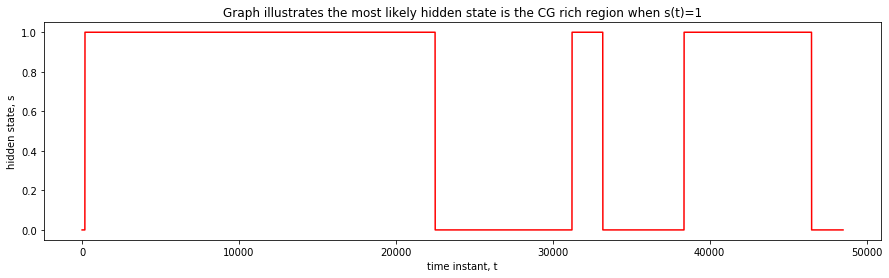

In [305]:
plot_result(result2)